In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from cleaning_data import clean
from get_macrodata import monthly_data
import sys
from scipy.optimize import minimize

Текущая рабочая директория: c:\Users\vasil\YandexDisk\project\LK_and_commets 
Оттуда буду брать данные, там должна быть папка data, а в ней данные по годам


c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [2]:
monthly_data['spread'] =  monthly_data.loc[:, 'ruonia'] - monthly_data.loc[:, 'rate_1']
var_spec = clean(monthly_data.loc[monthly_data.index > dt(2014, 6, 1), ['PMI_manufacturing', 'ru_cpi', 'real_ruonia', 'spread',
                                                                         'log_credits_hh', 'real_brent', 'pi_e', 'real_dollar']])
monthly_data['pi_spread'] =  monthly_data.loc[:, 'pi_e_wos'] - monthly_data.loc[:, 'pi_e_ws']
monthly_data['spread'].notna().sum()

Это pandas DataFrame!


np.int64(140)

In [3]:
from typing import Optional, Tuple, Union

def OLS_estimation(
                   Nseries, #numpy array
                   lag: int = 1,
                   from_class : bool = True,
                   lag_exog: int = 1,

                   exog_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int]:

    X = Nseries.values
    p = lag
    K, T = X.shape
    # Основные лаги 
    p_ex = lag_exog
    if exog_data is not None:
        X_ex = exog_data.values
    
    # Основные лаги 
    Z = np.hstack(
        [np.concatenate([np.array([1]), X[:, i:i+p].T.flatten()]).reshape(-1, 1) # type: ignore
            for i in range(T - p)]
    )[:, 1:]
    if exog_data is not None:
        Z_ex = np.hstack(
        [X_ex[:, i:i+p_ex].T.flatten().reshape(-1, 1) # type: ignore
            for i in range(T - p_ex)])[:, 1:]
    
    if exog_data is not None:
        if p > p_ex:
            Z = np.vstack([Z, Z_ex[:, :p_ex-p]])
        elif p == p_ex:
            Z = np.vstack([Z, Z_ex])
        else:
            Z = np.vstack([Z[:, :p-p_ex], Z_ex])
    Y = X[:, :Z.shape[1]]

    B_hat = Y @ Z.T @ np.linalg.inv(Z @ Z.T)
    E = Y - B_hat @ Z
    B_hat_endo = B_hat[:, :K*p+1]
    P = np.linalg.cholesky(E@E.T)
    return Z, Y, B_hat, E, X.shape[0], T, B_hat_endo, P # type: ignore
def irf_companion(
        A_mats : np.ndarray,
        B : np.ndarray, 
        horizon : int
                  ):
    """
    A_mats : list of A_i, i=1..p, каждая (n x n)
    B      : impact matrix (n x n)
    horizon: максимальный лаг
    """
    K = A_mats.shape[0]
    lag = int((A_mats.shape[1])/K)

    # Companion matrix
    
    bottom = np.eye(K*(lag-1), K*lag)
    A_comp = np.vstack([A_mats, bottom])

    # Selector
    J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

    irfs = []
    for h in range(0, horizon):
        Ah = np.linalg.matrix_power(A_comp, h)
        irfs.append(J @ Ah @ J.T @ B)
    return np.array(irfs)
def random_orthogonal(K):
    Q, _ = np.linalg.qr(np.random.normal(size=(K,K)))
    return Q

def get_irf_for_restrictions(restrictions, # список списков, где по срокам ограничения формата [строка, столбец, глубина, знак в формате (1, -1)]
                             P, # разложение Холетского
                             Q, # матрица поворота
                             B_hat_endo, # оцененная матрица коэффициентов
                             transition_matrix = None # марица линейных индентификационных ограничений на структурные шоки
                             ):
    K = P.shape[0]
    lag = B_hat_endo.shape[1]//K
    if transition_matrix is None:
        transition_matrix = np.identity(K)
    
    A_mats = B_hat_endo[:, 1:]
    bottom = np.eye(K*(lag-1), K*lag)
    A_comp = np.vstack([A_mats, bottom])
    J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])
    depth_list = list(set([i[2] for i in restrictions]))
    irf_dict = {}
    for deep in depth_list:
        irf_dict[deep] = J @ np.linalg.matrix_power(A_comp, deep) @ J.T @ P @ Q @ transition_matrix 
    result = {}
    for rest in restrictions:
        char_key = ' | '.join([str(i) for i in rest])
        irf_value = irf_dict[rest[2]][rest[0], rest[1]]
        result[char_key] = (rest[3] * irf_value > 0, # Булевое значение проверки выполнения знака
                            irf_value # число для функции потерь
                            )
    return result


def long_run_matrix(A, # B_hat_endo
                    B0inv):
    """Долгосрочная матрица C(∞)"""
    
    K = B0inv.shape[0]
    lag = A.shape[0]//K

    A_list = []
    for i in range(lag):
        A_list.append(A[:, 1+i*K:1+(1+i)*K])

    M = np.eye(K) - sum(A_list)
    M_inv = np.linalg.inv(M)
    return M_inv @ B0inv


def loss_fn(params, P, A,
            short_run_zeros, 
            long_run_zeros, 
            short_sign_restrictions, 
            long_sign_restrictions):
    """Loss: short-run и long-run ограничения"""
    K = P.shape[0]
    # Собрать Q из углов (Givens rotation)
    Q = np.eye(K)
    idx = 0
    for i in range(K-1):
        for j in range(i+1, K):
            theta = params[idx]; idx += 1
            G = np.eye(K)
            G[i,i] = np.cos(theta); G[i,j] = -np.sin(theta)
            G[j,i] = np.sin(theta); G[j,j] = np.cos(theta)
            Q = Q @ G

    B0inv = P @ Q
    Cinf = long_run_matrix(A, B0inv)

    loss = 0.0
    # short-run
    if len(short_run_zeros) > 0:
        for (i,j) in short_run_zeros:
            loss += (B0inv[i,j])**2
    
    #short-run sign restrictions
    if len(short_sign_restrictions) > 0:
        irf_result = get_irf_for_restrictions(
            short_sign_restrictions,
            P,
            Q,
            B_hat_endo
        )
        for i, char_rest in enumerate(irf_result):
            loss += np.exp(-1*short_sign_restrictions[i][3]*irf_result[char_rest][1]) - 1 
    
    # long-run
    if len(long_run_zeros) > 0:
        for (i,j) in long_run_zeros:
            loss += (Cinf[i,j])**4

    # long_run sign_restrictions
    if len(long_sign_restrictions) > 0:
        for i, rest in enumerate(long_sign_restrictions):
            loss += np.exp(-1*long_sign_restrictions[i][2]*Cinf[rest[0],rest[1]]) - 1
    
    

    return loss


def build_Q_from_params(params, K):
    Q = np.eye(K)
    idx = 0
    for i in range(K-1):
        for j in range(i+1, K):
            theta = params[idx]; idx += 1
            G = np.eye(K)
            G[i,i] = np.cos(theta);  G[i,j] = -np.sin(theta)
            G[j,i] = np.sin(theta);  G[j,j] = np.cos(theta)
            Q = Q @ G
    return Q

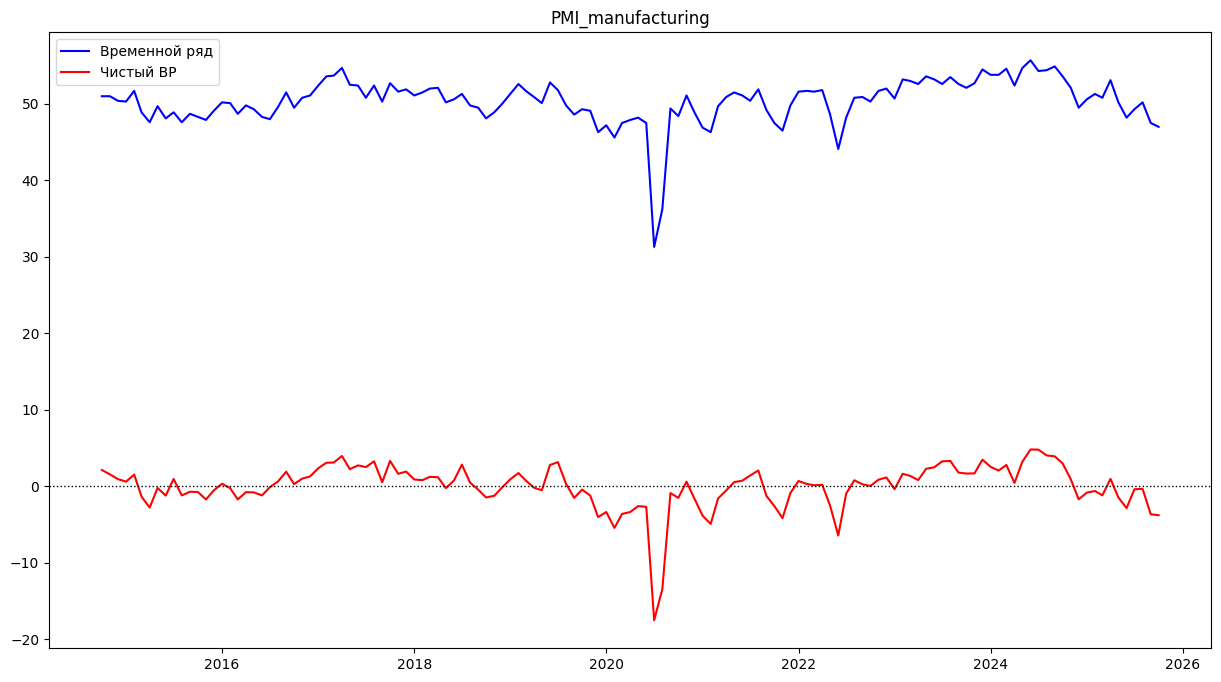

Исходный ряд PMI_manufacturing оказался стационарным


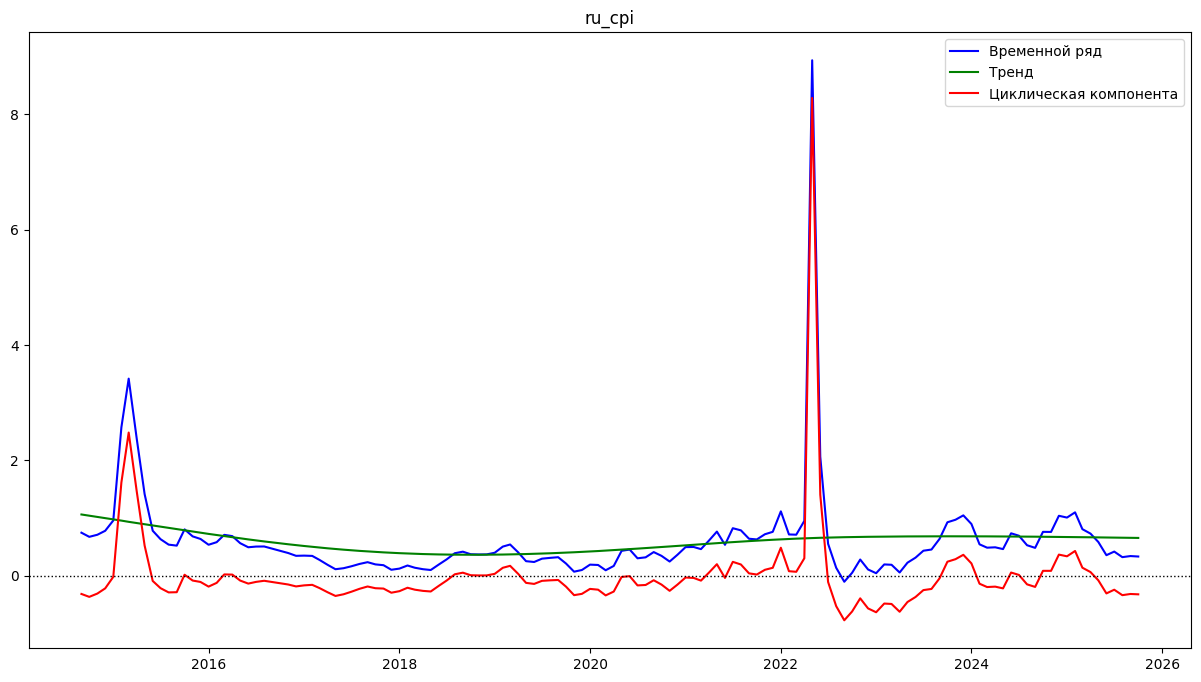

Исходный ряд ru_cpi оказался стационарным


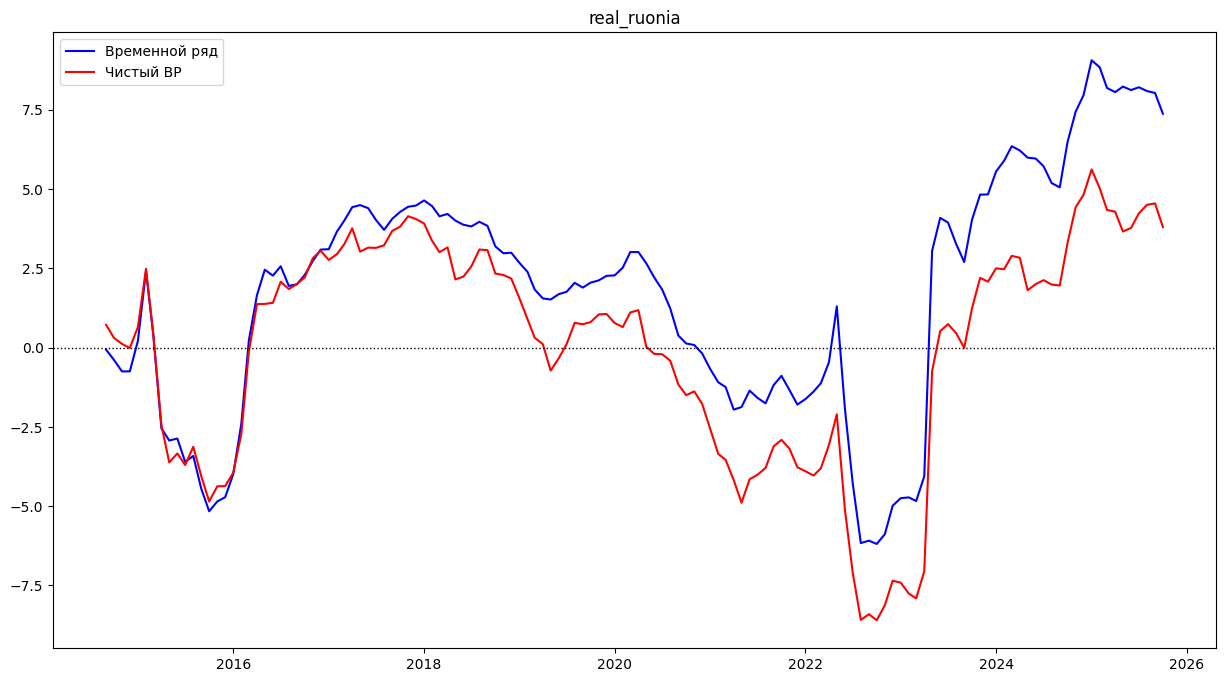

Исходный ряд real_ruonia оказался стационарным


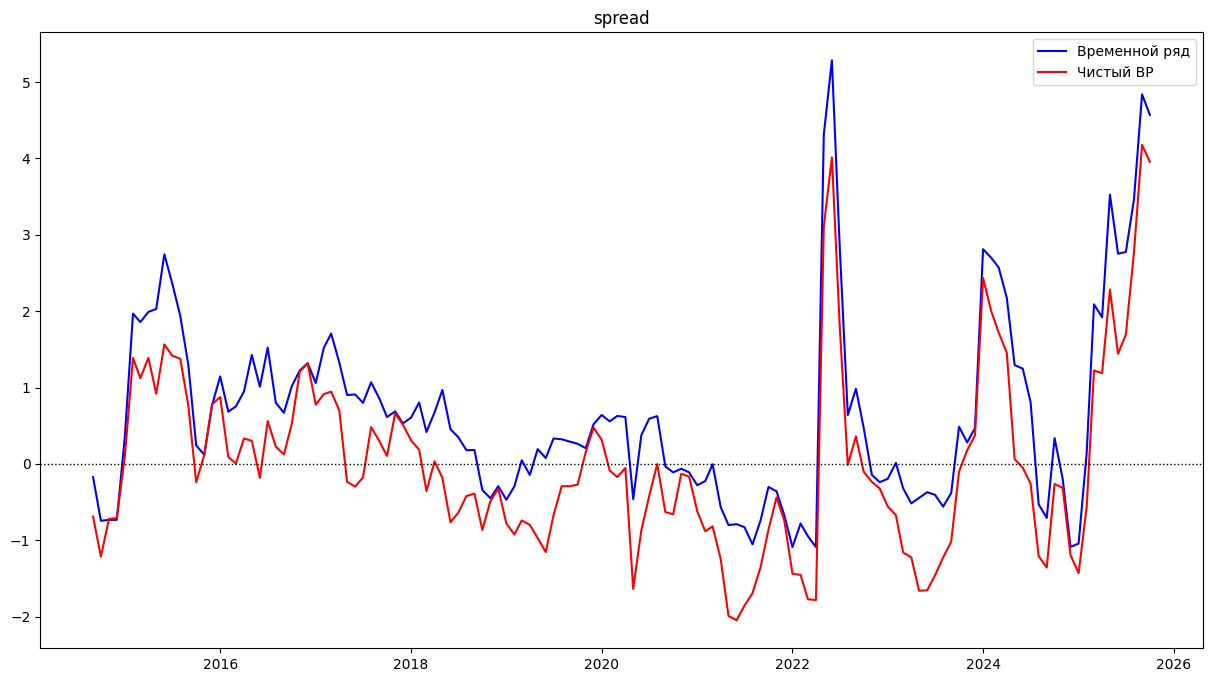

Исходный ряд spread оказался стационарным


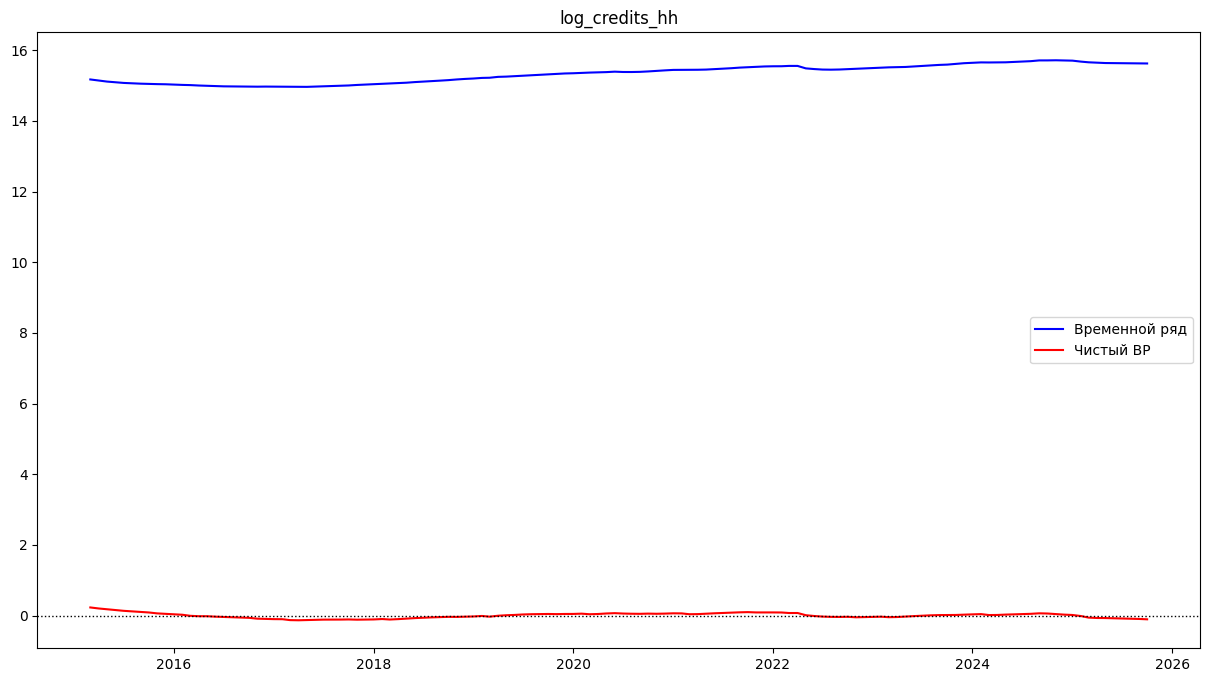

Исходный ряд log_credits_hh оказался стационарным


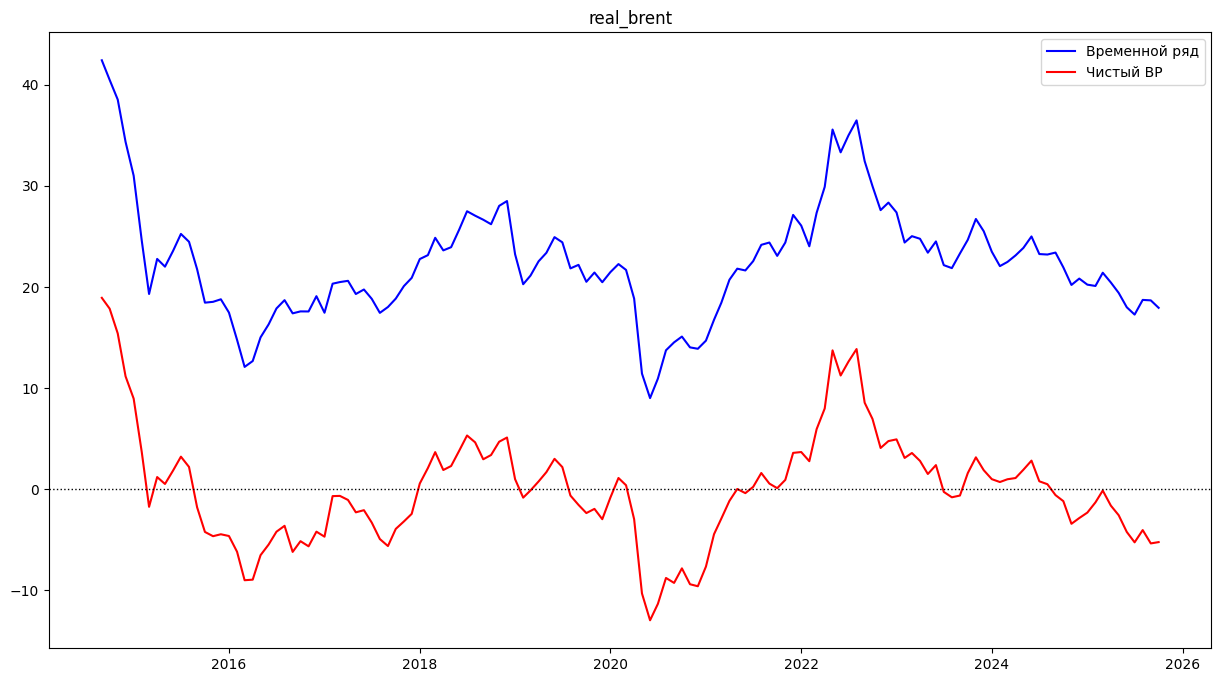

Исходный ряд real_brent оказался стационарным
Обрати внимание, что для переменной var_name есть пробел в данных
между 73 и 68 наблюдениями длинной больше 2


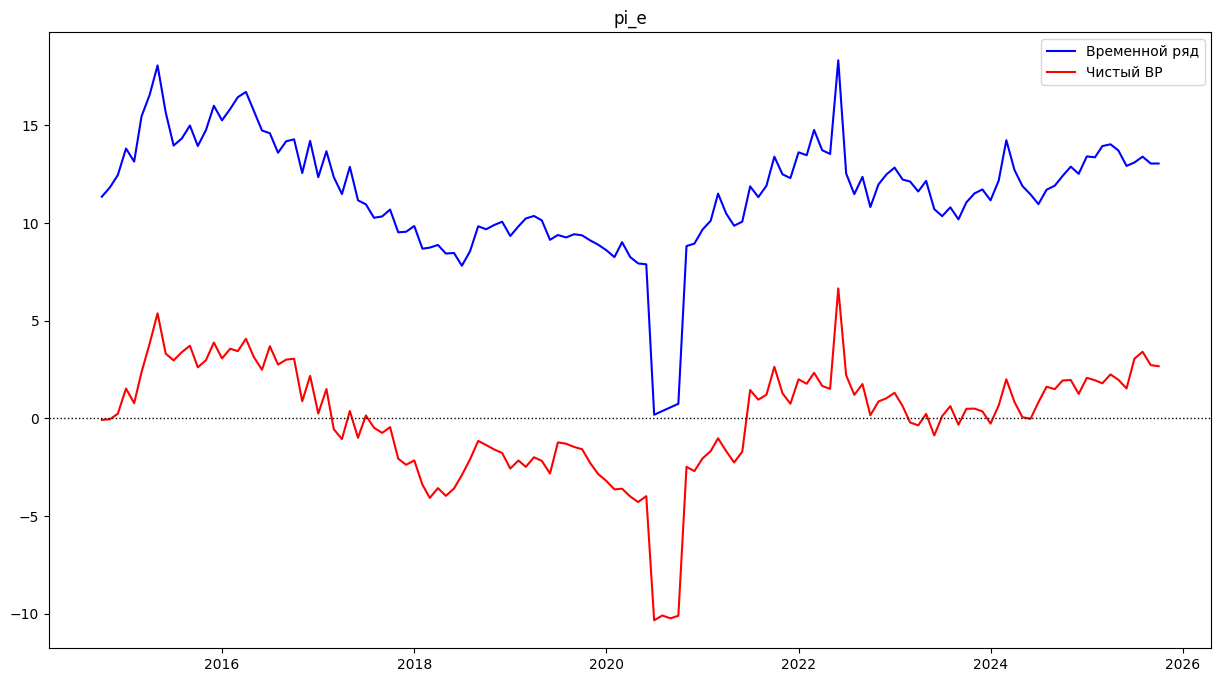

Исходный ряд pi_e оказался стационарным


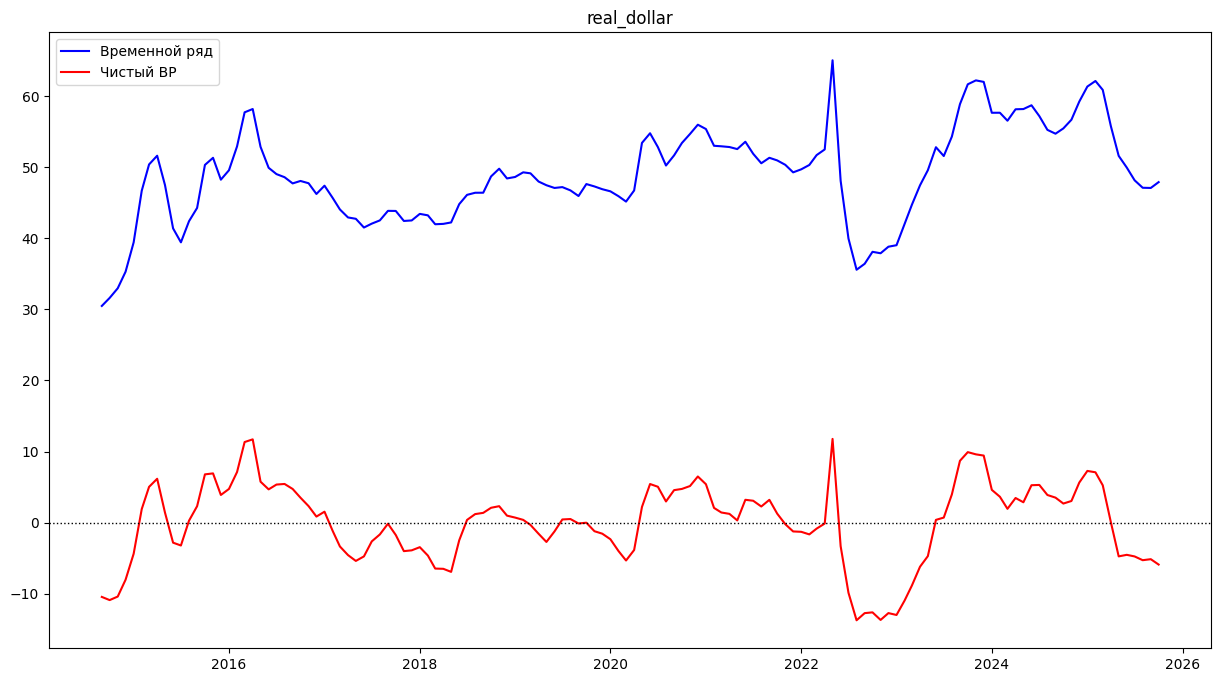

Исходный ряд real_dollar оказался стационарным


In [4]:
df, data = var_spec.LOS(use_harmonics=False, only_KPSS = True, hp_filter_map={
                                                                               'ru_cpi': True,
                                                                               'real_rate': False,
                                                                               'm2x_sa_mom': True})
covid_start, duration_covid = (data.T.index < dt(2020, 3, 1)).sum(), 5
svo_start, svo_duration = (data.T.index < dt(2022, 2, 1)).sum(), 2

data = data.T.sort_index(ascending=False).T.copy(deep=True)
data.loc['covid', :] = np.concatenate([np.zeros(data.shape[1]-covid_start-duration_covid), np.ones(duration_covid), np.zeros(covid_start)])
#data.loc['svo', :] = np.concatenate([np.zeros(svo_start), np.ones(svo_duration), np.zeros(data.shape[1]-svo_start-svo_duration)])
data = data.copy(deep = True)
data.loc['pi_e', (data.T.index > dt(2020, 3, 1)) & (data.T.index < dt(2020, 8, 1))] = data.loc['pi_e', (data.T.index > dt(2020, 3, 1)) & (data.T.index < dt(2020, 8, 1))].copy() +7

In [5]:
lag, lag_ex = 4, 1

Z, Y, B_hat, E, K, T, B_hat_endo, P = OLS_estimation( # type: ignore
    data.loc[[
    'PMI_manufacturing',
    'ru_cpi',
    'real_ruonia',
    'real_dollar',
    'pi_e'
       
], :], 
    lag = lag, 
    exog_data = data.loc[[
    'real_brent'
], :],  # type: ignore
    lag_exog=lag_ex)
K_endo, K_exog = P.shape[0], B_hat.shape[1] - K*lag - 1
u_dict = {0: 'шок AS',
          1: 'шок AD',
          2: 'шок ДКП',
          3: 'шока спроса на валюту',
          4: 'шок ИО'}
y_dict = {0: 'выпуск',
          1: 'инфляция',
          2: 'реальная RUONIA',
          3: 'Реальный курс доллара',
          4: 'ИО'}

Найдено матриц: 1000/1000 (100.0%), Использовано симуляций: 1000
Параметр жесткости 100.00%
[0, 2]


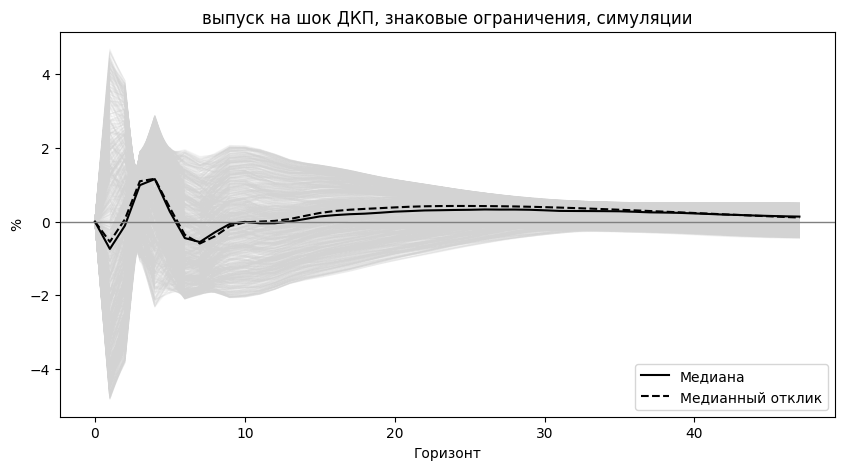

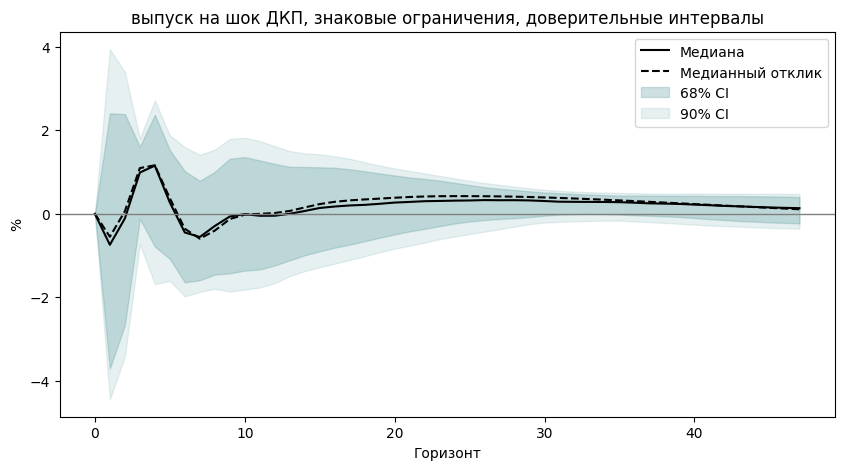

Вероятность, что суммарный отклик положительный 0.665, горизонт 48 мес.
Медианный суммарный отклик  8.32396, горизонт 48 мес.
Верхние 95% суммарный отклик  51.98555, горизонт 48 мес.
Нижние 5% суммарный отклик  -42.71611, горизонт 48 мес.
[0, 3]


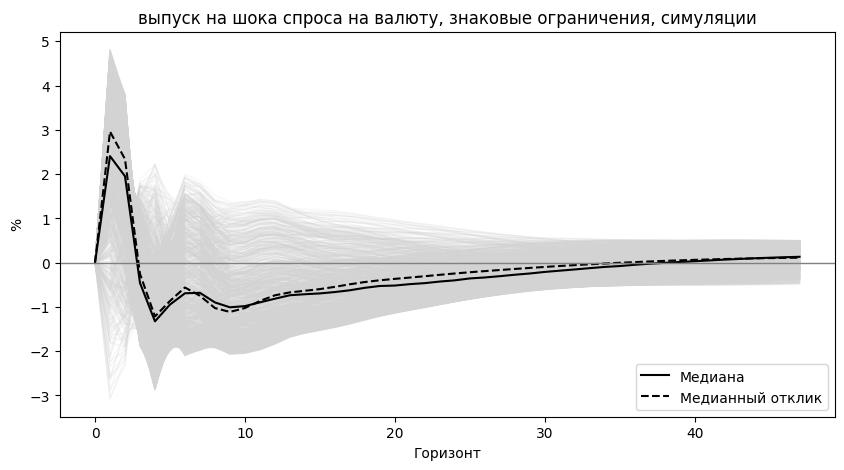

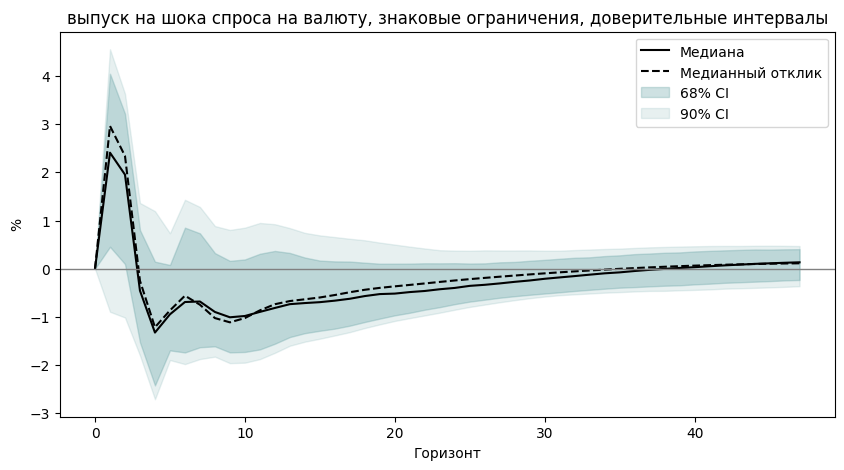

Вероятность, что суммарный отклик положительный 0.208, горизонт 48 мес.
Медианный суммарный отклик  -12.85683, горизонт 48 мес.
Верхние 95% суммарный отклик  35.24722, горизонт 48 мес.
Нижние 5% суммарный отклик  -47.74283, горизонт 48 мес.
[0, 4]


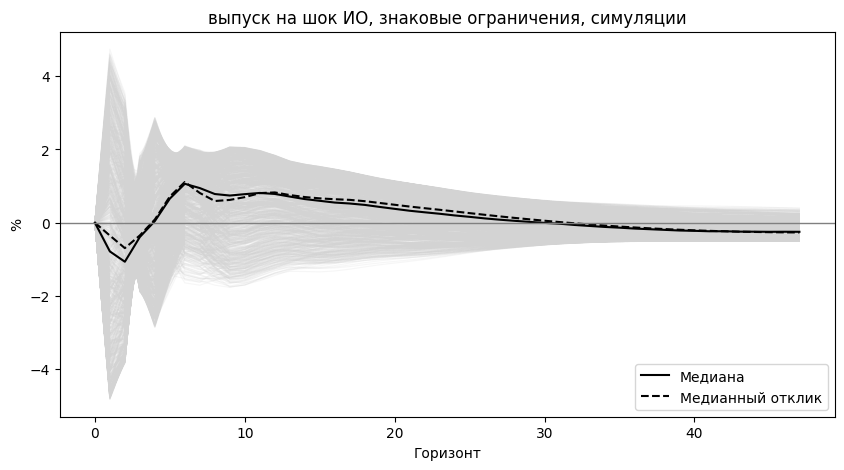

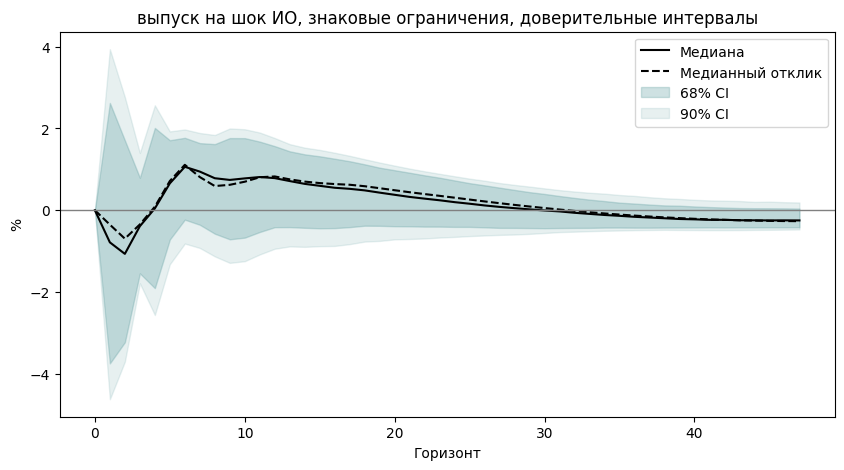

Вероятность, что суммарный отклик положительный 0.635, горизонт 48 мес.
Медианный суммарный отклик  7.02565, горизонт 48 мес.
Верхние 95% суммарный отклик  49.5396, горизонт 48 мес.
Нижние 5% суммарный отклик  -42.68655, горизонт 48 мес.
[1, 2]


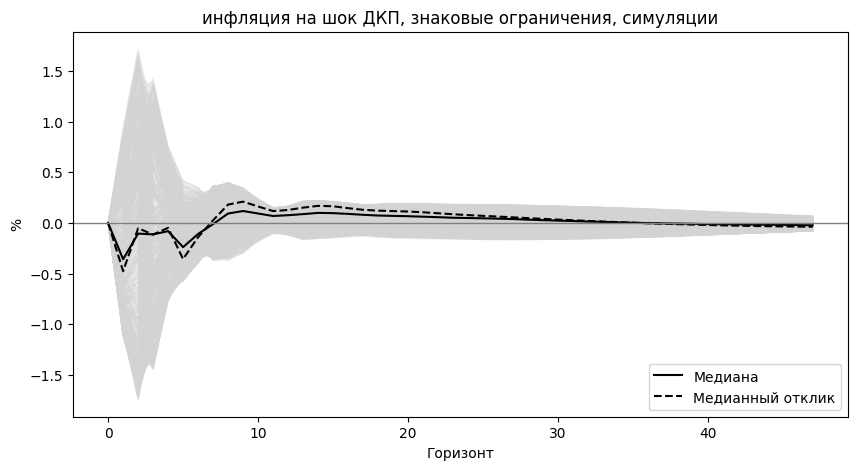

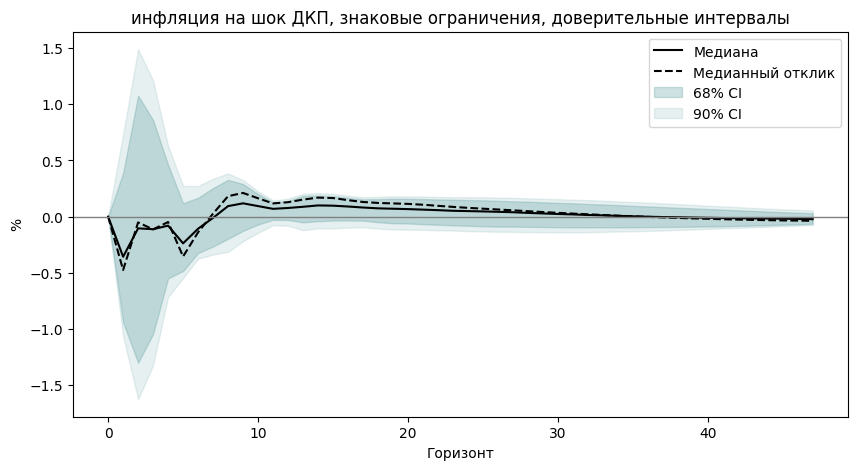

Вероятность, что суммарный отклик отрицательный 0.47, горизонт 48 мес.
Медианный суммарный отклик  0.45091, горизонт 48 мес.
Верхние 95% суммарный отклик  11.15759, горизонт 48 мес.
Нижние 5% суммарный отклик  -10.89294, горизонт 48 мес.
[1, 3]


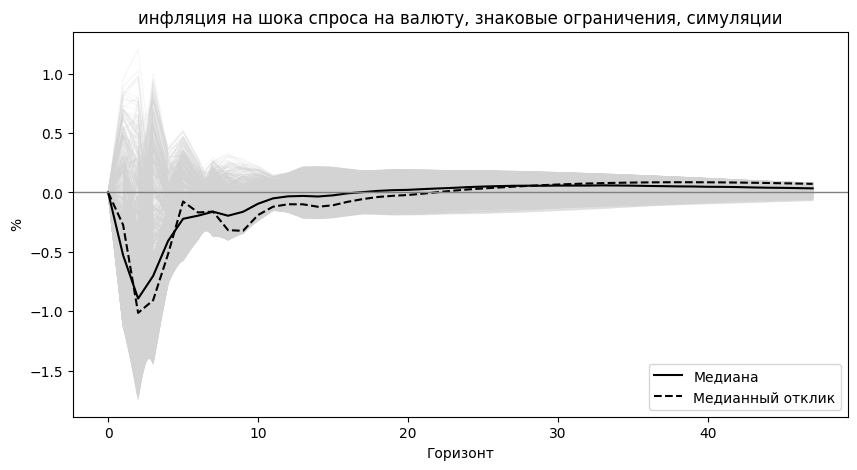

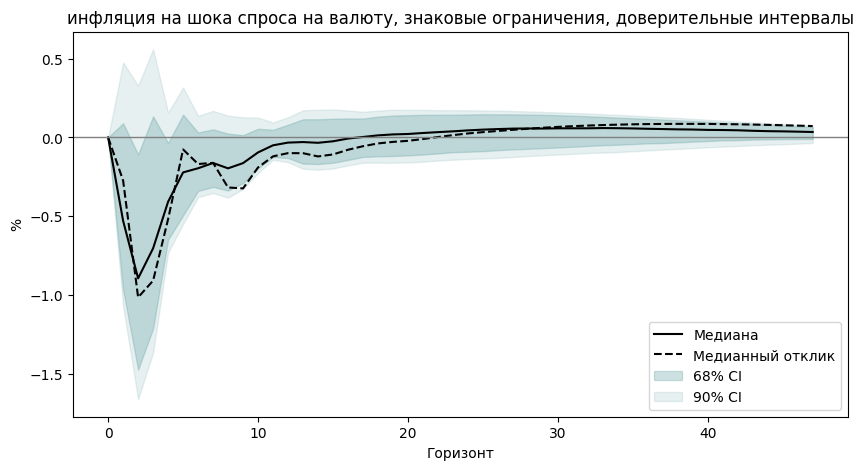

Вероятность, что суммарный отклик отрицательный 0.755, горизонт 48 мес.
Медианный суммарный отклик  -2.38238, горизонт 48 мес.
Верхние 95% суммарный отклик  7.8018, горизонт 48 мес.
Нижние 5% суммарный отклик  -11.23292, горизонт 48 мес.
[1, 4]


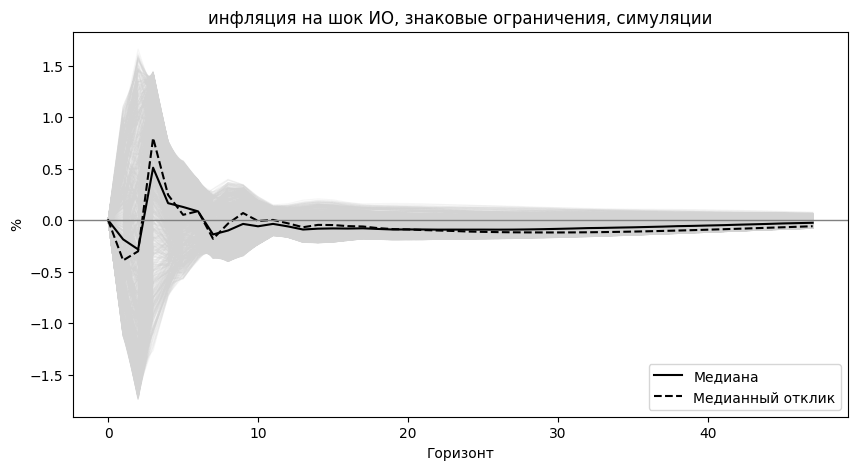

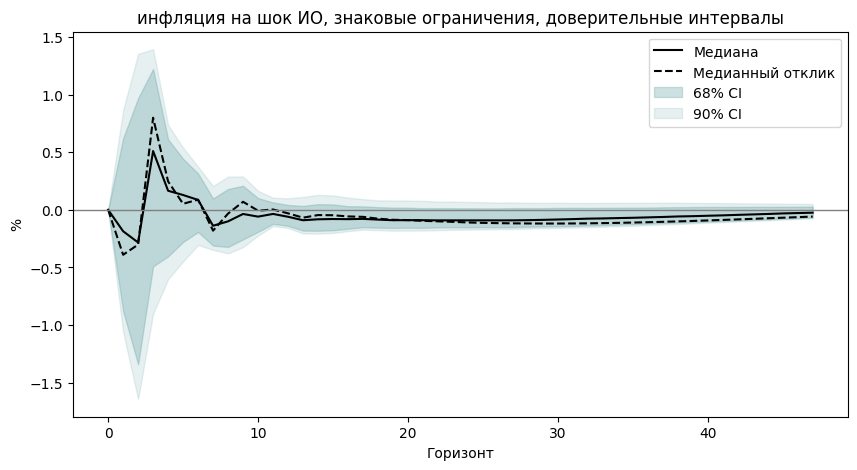

Вероятность, что суммарный отклик отрицательный 0.736, горизонт 48 мес.
Медианный суммарный отклик  -2.51453, горизонт 48 мес.
Верхние 95% суммарный отклик  8.86044, горизонт 48 мес.
Нижние 5% суммарный отклик  -11.7212, горизонт 48 мес.
[2, 2]


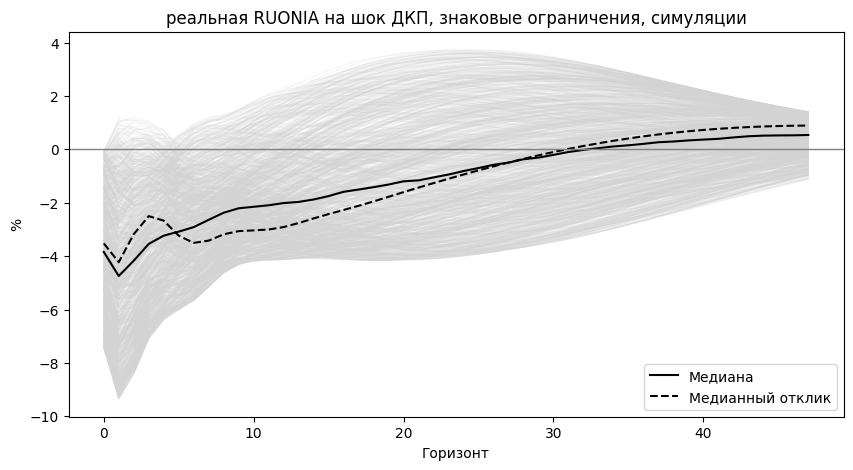

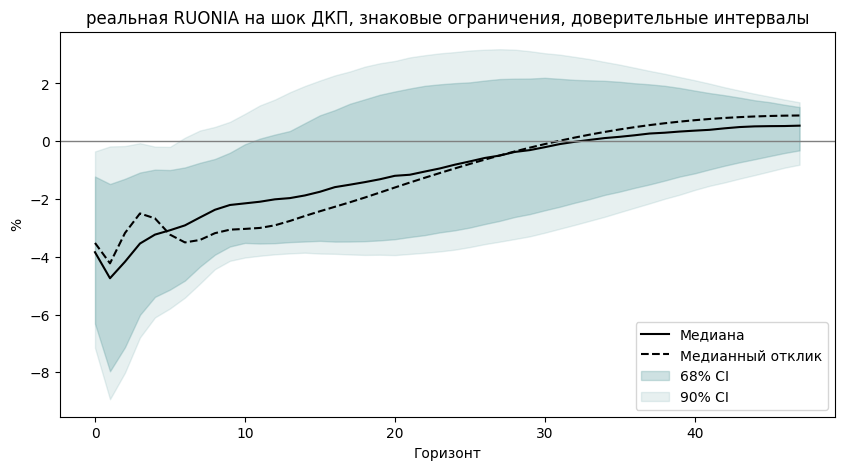

Вероятность, что суммарный отклик положительный 0.253, горизонт 48 мес.
Медианный суммарный отклик  -53.1297, горизонт 48 мес.
Верхние 95% суммарный отклик  90.89201, горизонт 48 мес.
Нижние 5% суммарный отклик  -172.71397, горизонт 48 мес.
[2, 3]


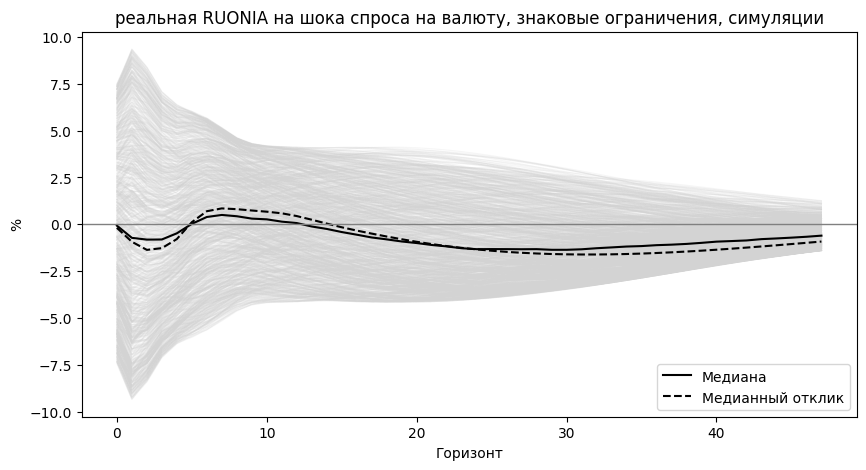

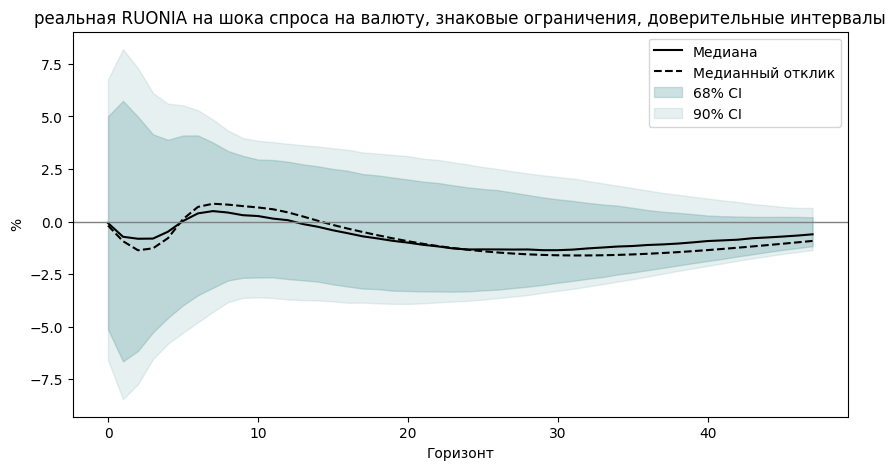

Вероятность, что суммарный отклик положительный 0.381, горизонт 48 мес.
Медианный суммарный отклик  -35.20067, горизонт 48 мес.
Верхние 95% суммарный отклик  142.76875, горизонт 48 мес.
Нижние 5% суммарный отклик  -173.40725, горизонт 48 мес.
[2, 4]


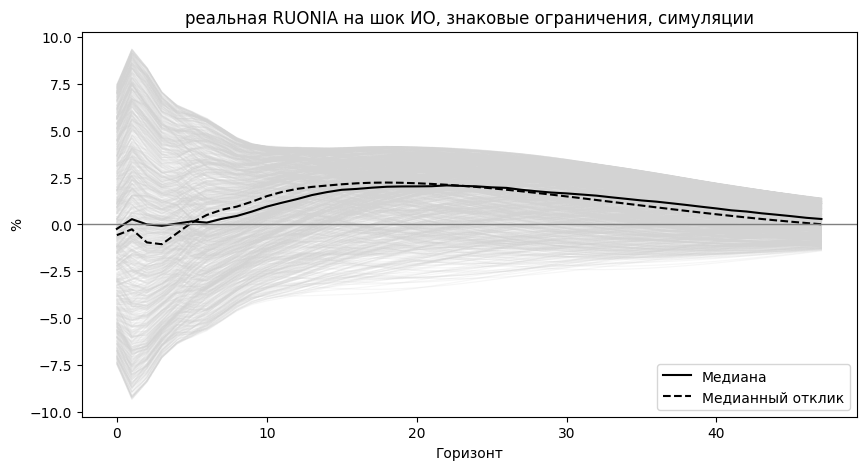

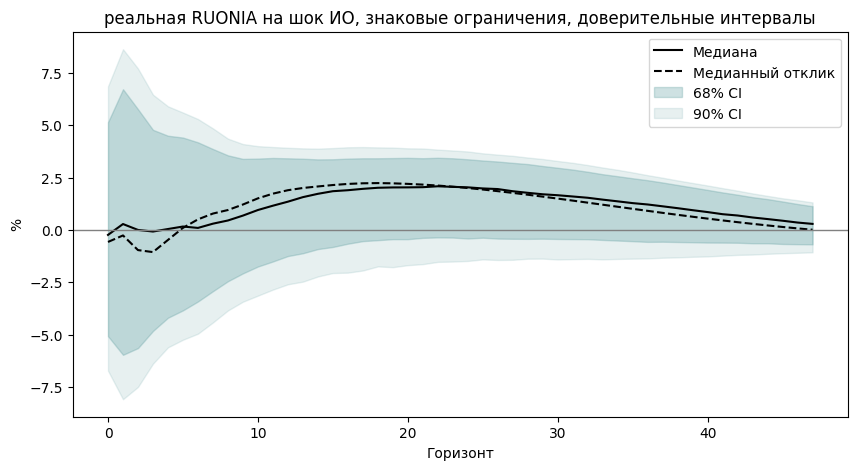

Вероятность, что суммарный отклик положительный 0.73, горизонт 48 мес.
Медианный суммарный отклик  55.53484, горизонт 48 мес.
Верхние 95% суммарный отклик  177.5258, горизонт 48 мес.
Нижние 5% суммарный отклик  -116.59708, горизонт 48 мес.
[3, 2]


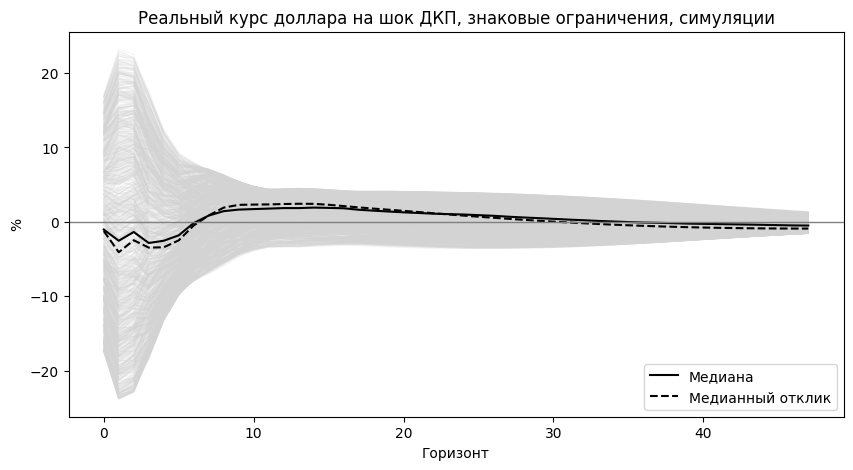

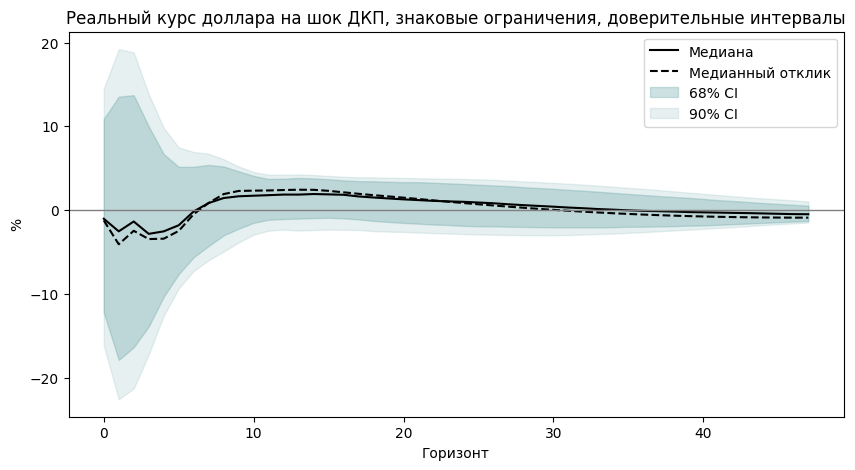

Вероятность, что суммарный отклик положительный 0.542, горизонт 48 мес.
Медианный суммарный отклик  15.09579, горизонт 48 мес.
Верхние 95% суммарный отклик  224.65388, горизонт 48 мес.
Нижние 5% суммарный отклик  -216.92356, горизонт 48 мес.
[3, 3]


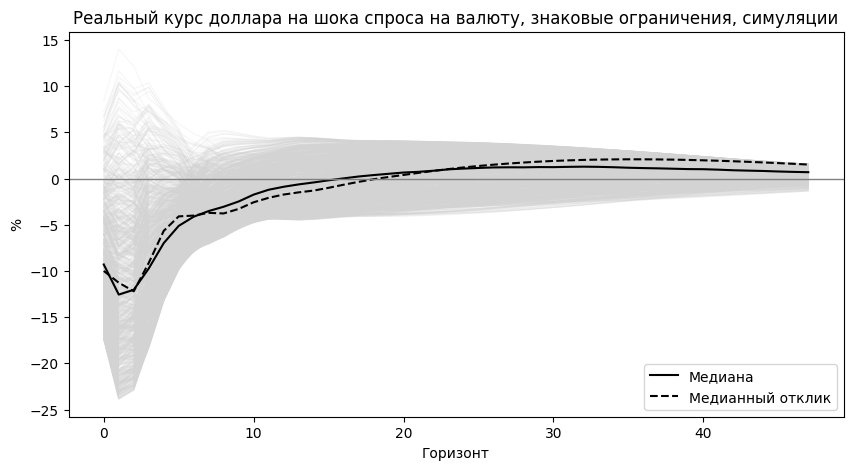

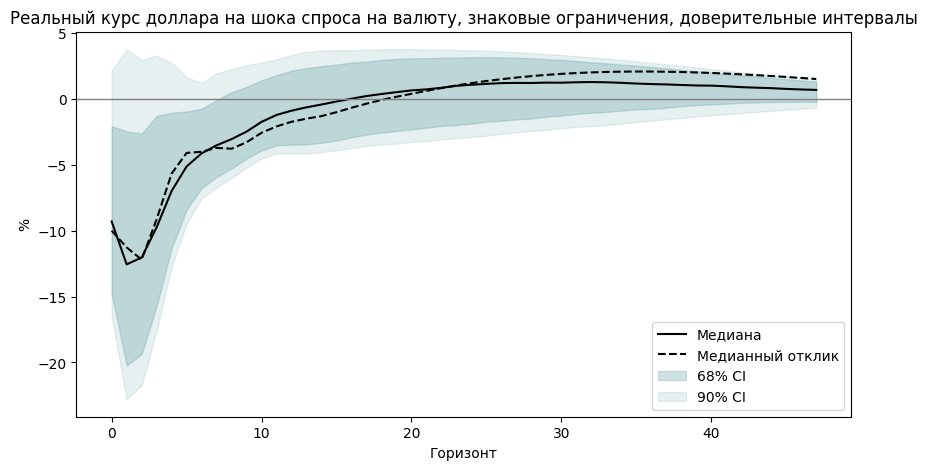

Вероятность, что суммарный отклик положительный 0.273, горизонт 48 мес.
Медианный суммарный отклик  -43.9978, горизонт 48 мес.
Верхние 95% суммарный отклик  139.85877, горизонт 48 мес.
Нижние 5% суммарный отклик  -218.98636, горизонт 48 мес.
[3, 4]


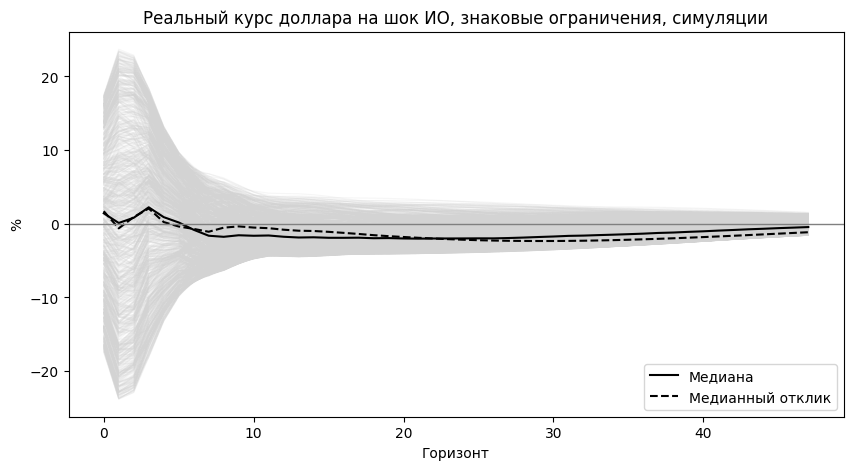

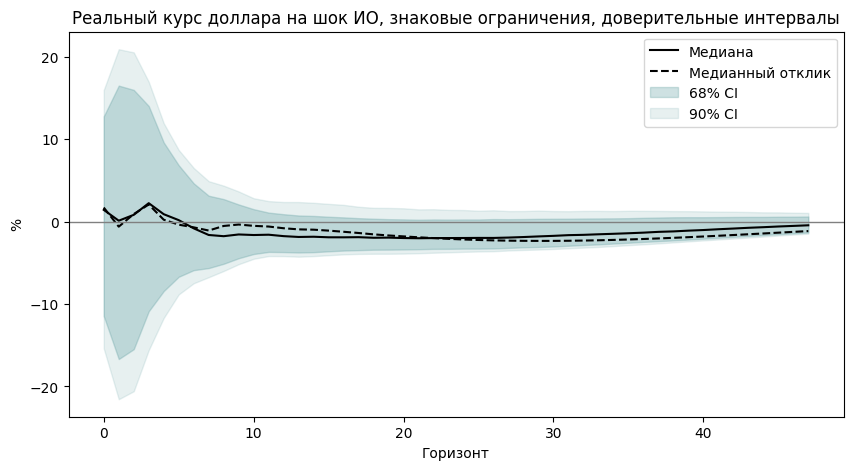

Вероятность, что суммарный отклик положительный 0.24, горизонт 48 мес.
Медианный суммарный отклик  -57.8888, горизонт 48 мес.
Верхние 95% суммарный отклик  172.39733, горизонт 48 мес.
Нижние 5% суммарный отклик  -240.40029, горизонт 48 мес.
[4, 2]


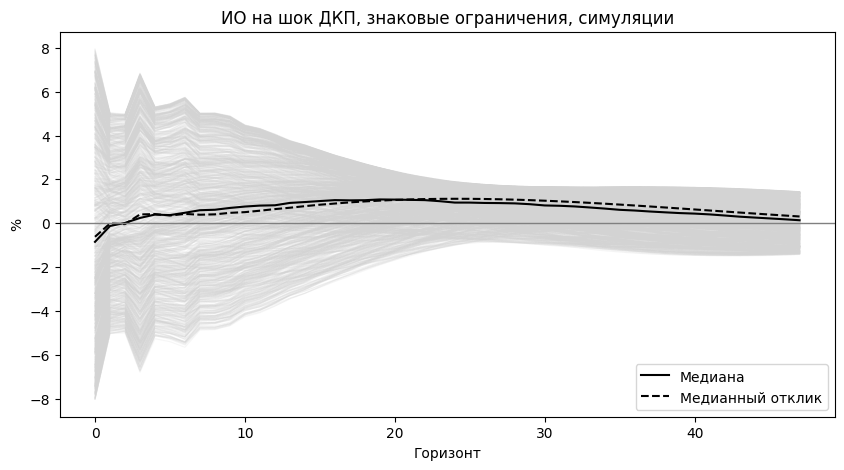

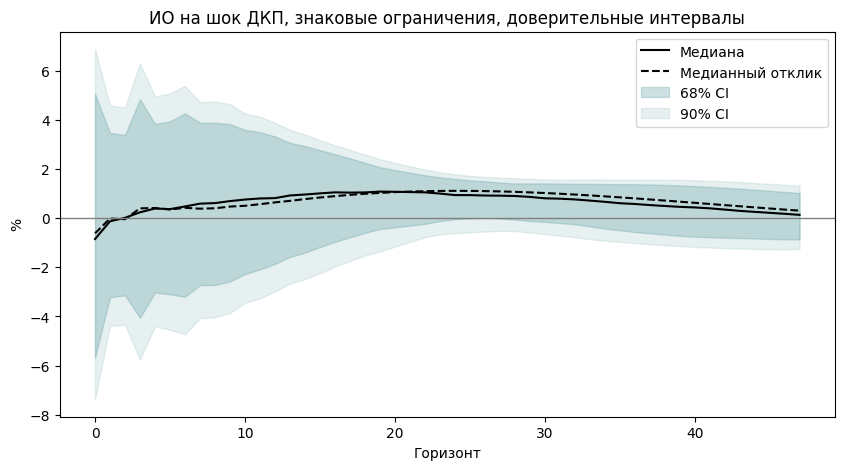

Вероятность, что суммарный отклик положительный 0.714, горизонт 48 мес.
Медианный суммарный отклик  30.44653, горизонт 48 мес.
Верхние 95% суммарный отклик  130.72885, горизонт 48 мес.
Нижние 5% суммарный отклик  -97.04158, горизонт 48 мес.
[4, 3]


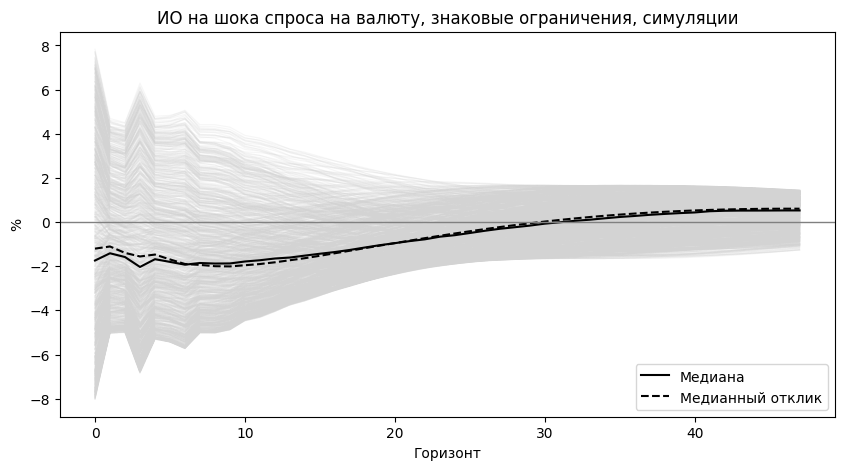

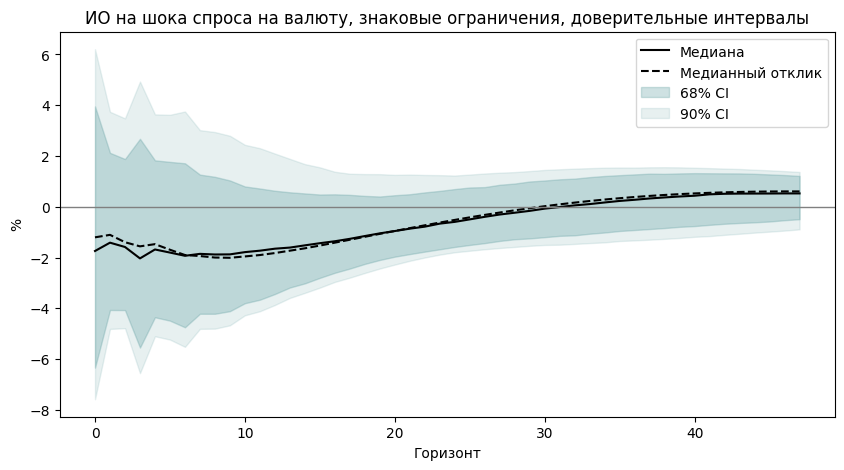

Вероятность, что суммарный отклик положительный 0.279, горизонт 48 мес.
Медианный суммарный отклик  -31.95594, горизонт 48 мес.
Верхние 95% суммарный отклик  95.19272, горизонт 48 мес.
Нижние 5% суммарный отклик  -127.4468, горизонт 48 мес.
[4, 4]


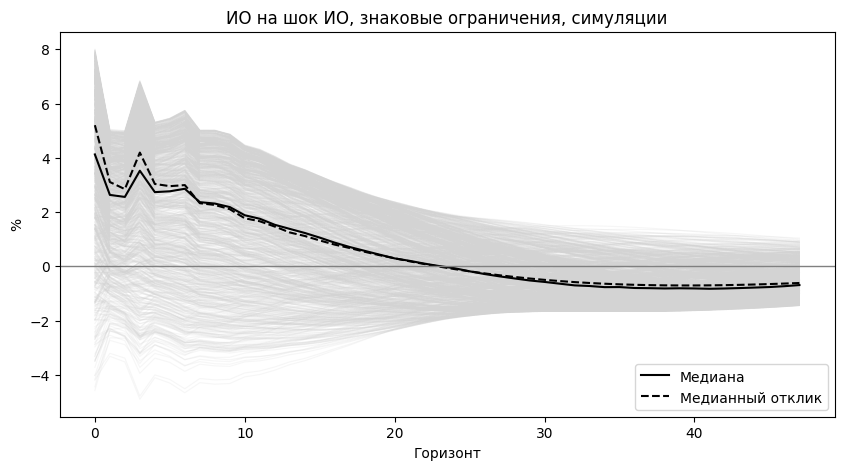

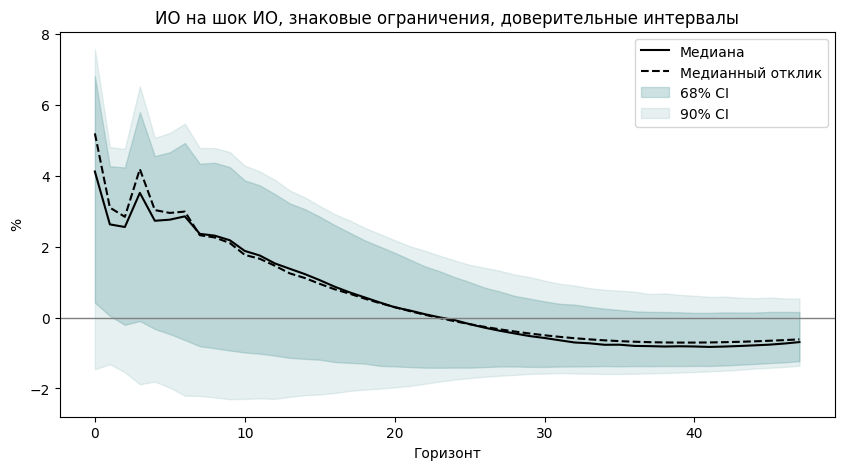

Вероятность, что суммарный отклик положительный 0.663, горизонт 48 мес.
Медианный суммарный отклик  24.56357, горизонт 48 мес.
Верхние 95% суммарный отклик  115.30923, горизонт 48 мес.
Нижние 5% суммарный отклик  -85.61362, горизонт 48 мес.


In [7]:
pluses0 = [
    [], []
]
minuses0 = [
    [], []
]
pluses1 = [
    [], []
]
minuses1 = [
    [], []
]
plus_spec = [
    
]
minus_spec = [

]
pluses0= [(np.array(pluses0[0])-1).tolist(), (np.array(pluses0[1])-1).tolist()]
pluses1 = [(np.array(pluses1[0])-1).tolist(), (np.array(pluses1[1])-1).tolist()]
minuses0 = [(np.array(minuses0[0])-1).tolist(), (np.array(minuses0[1])-1).tolist()]
minuses1 = [(np.array(minuses1[0])-1).tolist(), (np.array(minuses1[1])-1).tolist()]

import sys

required = 1000
np.random.seed(10)
A_mats = B_hat_endo[:, 1:]
lag = int((A_mats.shape[1])/K)

# Companion matrix

bottom = np.eye(K*(lag-1), K*lag)
A_comp = np.vstack([A_mats, bottom])

# Selector
J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

# number of negative and positive sign restrictions
trans_matrix = np.identity(K)
#trans_matrix[2,3] = 1
#trans_matrix[2,2] = 1
#trans_matrix[3,3] = 1
i = 0
sim = 0
accepted = []
while len(accepted) < required:

    Q = np.identity(K)
    Q_k = random_orthogonal(3)
    Q[2:, 2:] = Q_k

    
    B_inv = P@ trans_matrix @Q
    irf1 = J @ A_comp @ J.T @ B_inv
    irf2 = J @ np.linalg.matrix_power(A_comp, 2) @ J.T @ B_inv
    irf3 = J @ np.linalg.matrix_power(A_comp, 3) @ J.T @ B_inv
    irf4 = J @ np.linalg.matrix_power(A_comp, 4) @ J.T @ B_inv
    cond1 = np.sum(irf1[pluses1[0], pluses1[1]].flatten() > 0) == len(pluses1[0])  and np.sum(irf1[minuses1[0], minuses1[1]].flatten() < 0) == len(minuses1[0])
    cond2 = np.sum(irf2[pluses1[0], pluses1[1]].flatten() > 0) == len(pluses1[0])  and np.sum(irf2[minuses1[0], minuses1[1]].flatten() < 0) == len(minuses1[0])
    cond0 = np.sum(B_inv[pluses0[0], pluses0[1]].flatten() > 0) == len(pluses0[0]) and np.sum(B_inv[minuses0[0], minuses0[1]].flatten() < 0) == len(minuses0[0])

    irf_c1_4 = irf1 + irf2 + irf3 + irf4
    cond_spec_1_4_plus = np.array([irf_c1_4[r, s] > 0 for r, s in plus_spec]).sum() == len(plus_spec)
    cond_spec_1_4_minus = np.array([irf_c1_4[r, s] < 0 for r, s in minus_spec]).sum() == len(minus_spec)
    if cond0 and cond1 and cond2 and cond_spec_1_4_plus and cond_spec_1_4_minus:
        accepted.append(Q)
        i += 1
    sim += 1
    sys.stdout.write(f"\rНайдено матриц: {i}/{required} ({i*100/required:.1f}%), Использовано симуляций: {sim}")
    sys.stdout.flush()

print(f'\nПараметр жесткости {required*100/sim:.2f}%')
horizon = 48
IRF = []
for Q in accepted:
    IRF.append(irf_companion(B_hat_endo[:, 1:], P@trans_matrix@Q, horizon))
    

for i, j in [(i, j) for i in range(K_endo) for j in range(2, K_endo)]:
    irf = IRF[0]
    response = [i, j]
    print(response)
    virf = irf[:, response[0], response[1]]
    
    for irf in IRF[1:]:
        virf = np.vstack([virf, irf[:, response[0], response[1]]])
    median_index = pd.DataFrame((virf - np.median(virf, axis = 0))**2).sum(1).sort_values().index[0]
    import matplotlib.pyplot as plt

    # Имитация матрицы: 10000 симуляций × 20 шагов
    np.random.seed(0)
    responses = virf
    rescale = False
    if rescale:
        depend = data.iloc[response[0]].std()
        shock = data.iloc[response[1]].std()
        virf *= shock/depend
    # Квантили
    if j == 2:
        sign = 1
    else:
        sign = 1
    median = sign*np.percentile(responses, 50, axis=0)
    lower68 = sign*np.percentile(responses, 16, axis=0)
    upper68 = sign*np.percentile(responses, 84, axis=0)
    lower90 = sign*np.percentile(responses, 5, axis=0)
    upper90 = sign*np.percentile(responses, 95, axis=0)
    med_res = sign*virf[median_index, :]
    median_s = median.sum()
    upper90_s = upper90.sum()
    # Горизонты
    x_axis = np.arange(horizon)
    plt.figure(figsize=(10,5))
    plt.plot(x_axis, virf.T, color="lightgray", alpha=0.2, linewidth=0.8, label="_nolabel_")
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend(loc = 'lower right')
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, знаковые ограничения, симуляции")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.fill_between(x_axis, lower68, upper68, color='cadetblue', alpha=0.3, label='68% CI')
    plt.fill_between(x_axis, lower90, upper90, color='cadetblue', alpha=0.15, label='90% CI')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend()
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, знаковые ограничения, доверительные интервалы")
    plt.show()
    print(f"Вероятность, что суммарный отклик {'отрицательный' if i == 1 else 'положительный'} {((virf.sum(axis = 1) < 0).sum()/required)\
                                                                         .item() if i == 1 else ((virf.sum(axis = 1) > 0).sum()/required).item()}, горизонт {horizon} мес.")
    print(f"Медианный суммарный отклик  {np.round(np.median(virf, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Верхние 95% суммарный отклик  {np.round(np.quantile(virf, 0.95, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Нижние 5% суммарный отклик  {np.round(np.quantile(virf, 0.05, axis = 0).sum(), 5)}, горизонт {horizon} мес.")

In [ ]:
from scipy.optimize import minimize

def long_run_matrix(A, # B_hat_endo
                    B0inv):
    """Долгосрочная матрица C(∞)"""
    
    K = B0inv.shape[0]
    lag = A.shape[0]//K

    A_list = []
    for i in range(lag):
        A_list.append(A[:, 1+i*K:1+(1+i)*K])

    M = np.eye(K) - sum(A_list)
    M_inv = np.linalg.inv(M)
    return M_inv @ B0inv


def loss_fn(params, P, A,
            short_run_zeros, 
            long_run_zeros, 
            short_sign_restrictions, 
            long_sign_restrictions):
    """Loss: short-run и long-run ограничения"""
    K = P.shape[0]
    # Собрать Q из углов (Givens rotation)
    Q = np.eye(K)
    idx = 0
    for i in range(K-1):
        for j in range(i+1, K):
            theta = params[idx]; idx += 1
            G = np.eye(K)
            G[i,i] = np.cos(theta); G[i,j] = -np.sin(theta)
            G[j,i] = np.sin(theta); G[j,j] = np.cos(theta)
            Q = Q @ G

    B0inv = P @ Q
    Cinf = long_run_matrix(A, B0inv)

    loss = 0.0
    # short-run
    if len(short_run_zeros) > 0:
        for (i,j) in short_run_zeros:
            loss += (B0inv[i,j])**2
    
    #short-run sign restrictions
    if len(short_sign_restrictions) > 0:
        irf_result = get_irf_for_restrictions(
            short_sign_restrictions,
            P,
            Q,
            B_hat_endo
        )
        for i, char_rest in enumerate(irf_result):
            loss += np.exp(-1*short_sign_restrictions[i][3]*irf_result[char_rest][1]) - 1 
    
    # long-run
    if len(long_run_zeros) > 0:
        for (i,j) in long_run_zeros:
            loss += (Cinf[i,j])**4

    # long_run sign_restrictions
    if len(long_sign_restrictions) > 0:
        for i, rest in enumerate(long_sign_restrictions):
            loss += np.exp(-1*long_sign_restrictions[i][2]*Cinf[rest[0],rest[1]]) - 1
    
    

    return loss


def build_Q_from_params(params, K):
    Q = np.eye(K)
    idx = 0
    for i in range(K-1):
        for j in range(i+1, K):
            theta = params[idx]; idx += 1
            G = np.eye(K)
            G[i,i] = np.cos(theta);  G[i,j] = -np.sin(theta)
            G[j,i] = np.sin(theta);  G[j,j] = np.cos(theta)
            Q = Q @ G
    return Q

$$
\theta_{k+1} = \theta_k - H_k^{-1} \nabla L(\theta_k)
$$

In [8]:
short_run_zeros = [(0,1), (1, 0)]  # нули в B0inv
long_run_zeros = [(0,1), (0,2), (0,3), (2, 2)]   # нули в C(∞)
short_sign_restrictions = [
    [1, 2, 1 ,-1],
    [2, 2, 0 ,1],
    [2, 2, 1 ,1],
]
long_sign_restrictions = [
    [1, 2, -1]
]

best_loss = np.inf
best_res = None
n_starts = 100  # число случайных инициализаций

n_params = int(K_endo * (K_endo - 1) / 2)
rng = np.random.default_rng(100)

for s in range(n_starts):
    init_params = rng.uniform(0, 2*np.pi, size=n_params)

    res = minimize(
        loss_fn,
        init_params,
        args=(P, B_hat_endo,
              short_run_zeros,
              long_run_zeros,
              short_sign_restrictions,
              long_sign_restrictions),
        method='BFGS',
        options={'gtol': 1e-10, 'maxiter': 1000, 'disp': False}
    )

    if res.fun < best_loss:
        best_loss = res.fun
        best_res = res
    sys.stdout.write(f"\rПройдено: {s}/{n_starts} ({s*100/n_starts:.1f}%)")
    sys.stdout.flush()
print(f"Лучшее значение loss из {n_starts} стартов: {best_loss:.6e}")

Пройдено: 99/100 (99.0%)Лучшее значение loss из 100 стартов: -2.631475e+00


In [9]:
Q = build_Q_from_params(best_res.x, K_endo)
print(long_run_matrix(B_hat_endo, P @ Q))
print(P @ Q)

[[ 1.48629164e+02  3.22423286e-05  1.29173508e-01  5.40211577e-05
  -9.11783446e-01]
 [-1.48446797e+01  6.39623271e+00 -1.81291889e+00  6.63458455e-02
   8.42890055e+00]
 [ 1.76395598e+01  2.74398841e+01 -2.91207252e-01  2.94875394e+01
   1.60587621e+01]
 [-1.14808399e+02  4.13275265e+01  1.29857426e+01 -3.21444882e+01
   3.68201447e+00]
 [-2.84422293e+01 -5.27470575e+00 -1.92187340e+01 -1.33162104e+01
  -8.27082320e+00]]
[[ 1.15660909e+01 -7.90688541e-07  1.87827629e+00 -1.65613850e+01
  -8.11387770e+00]
 [-2.31756862e-07  1.95961416e+00 -3.44483068e+00 -6.06848848e-01
   6.81992954e+00]
 [-5.38578883e+00 -3.17177540e+00  1.00546335e+00 -3.63065829e+00
   1.91745961e+00]
 [ 3.09688012e+00 -1.14612271e+01 -1.45504114e+01 -1.32711495e-01
   1.03276651e+01]
 [-2.91568136e+00  1.19373455e+00 -8.76619730e+00 -1.50698382e+00
   9.35411581e-01]]


In [10]:
import sys

horizon = 12
required = 1000
ncoef = B_hat.shape[1]
IRF_ortho = []
IRF_ortho.append(irf_companion(B_hat_endo[:, 1:], P@Q, horizon))
T = E.shape[1]
for i in range(1, required):
    np.random.seed(i)
    indexes = np.random.choice(T, T).tolist()
    e_star = E[:, indexes]
    Z_new = Z[:, -1]
    y_b = B_hat@Z_new + e_star[:, -1]
    Y_b = np.hstack([y_b.reshape(-1, 1), Z_new[1:K_endo + 1].reshape(-1, 1)])

    for j in range(2, T-lag):
        
        if K_exog>0:
            Z_new = np.concatenate([np.array([1]), y_b, Z_new[1:K_endo*(lag-1)+1], Z[-(K_exog*lag_ex):, -(j)]])   
        else: 
            Z_new = np.concatenate([np.array([1]), y_b, Z_new[1:K_endo*(lag - 1)+1]])
        y_b = B_hat@Z_new + e_star[:, -j]
        Y_b = np.hstack([y_b.reshape(-1, 1), Y_b])
    B_hat_new, P_new = OLS_estimation(pd.DataFrame(Y_b), lag = lag)[6:] # type: ignore

    IRF_ortho.append(irf_companion(B_hat_new[:, 1:], P_new@Q, horizon))

    sys.stdout.write(f"\rПосчитанно матриц: {i}/{required-1} ({i*100/(required-1):.1f}%)")
    sys.stdout.flush()

Посчитанно матриц: 999/999 (100.0%)

[0, 2]


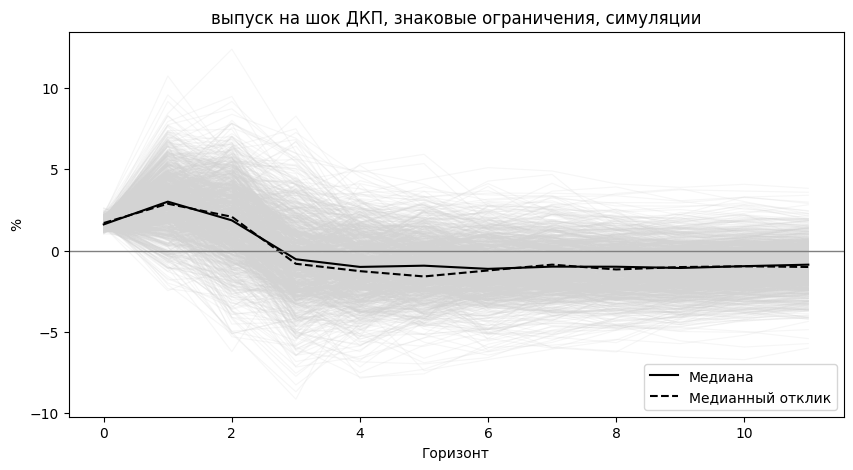

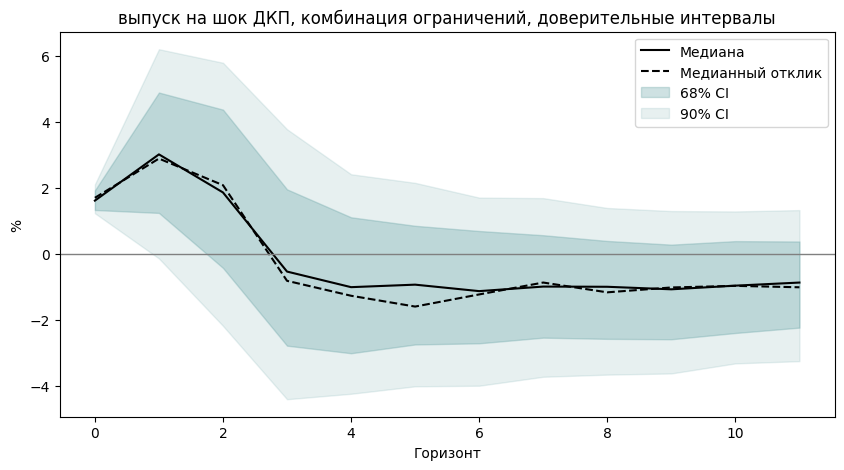

Вероятность, что суммарный отклик положительный 0.447, горизонт 12 мес.
Медианный суммарный отклик  -2.03058, горизонт 12 мес.
Верхние 95% суммарный отклик  31.07067, горизонт 12 мес.
Нижние 5% суммарный отклик  -35.2928, горизонт 12 мес.
[0, 3]


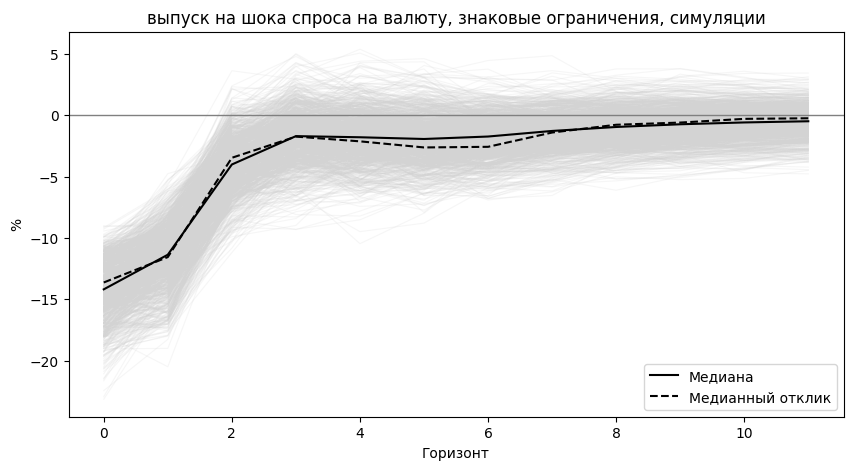

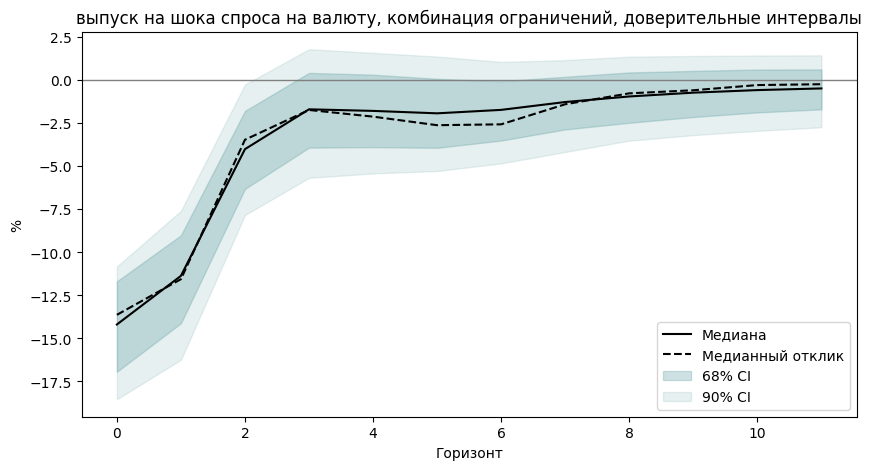

Вероятность, что суммарный отклик положительный 0.0, горизонт 12 мес.
Медианный суммарный отклик  -40.87158, горизонт 12 мес.
Верхние 95% суммарный отклик  -6.26534, горизонт 12 мес.
Нижние 5% суммарный отклик  -80.48593, горизонт 12 мес.
[0, 4]


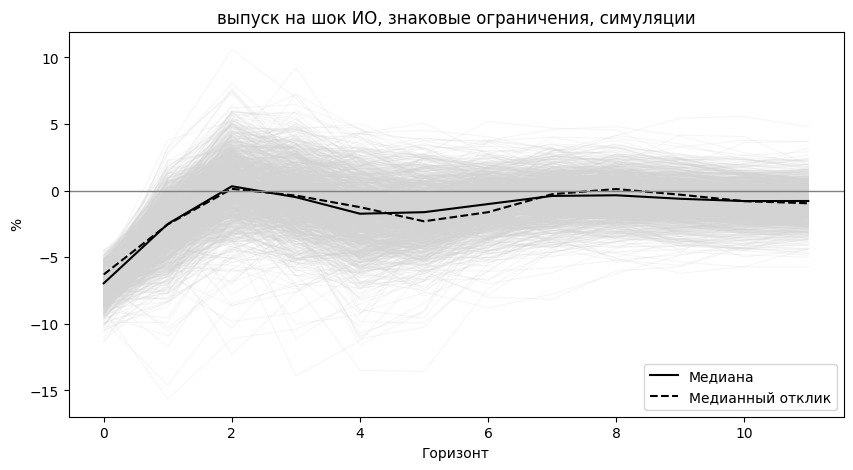

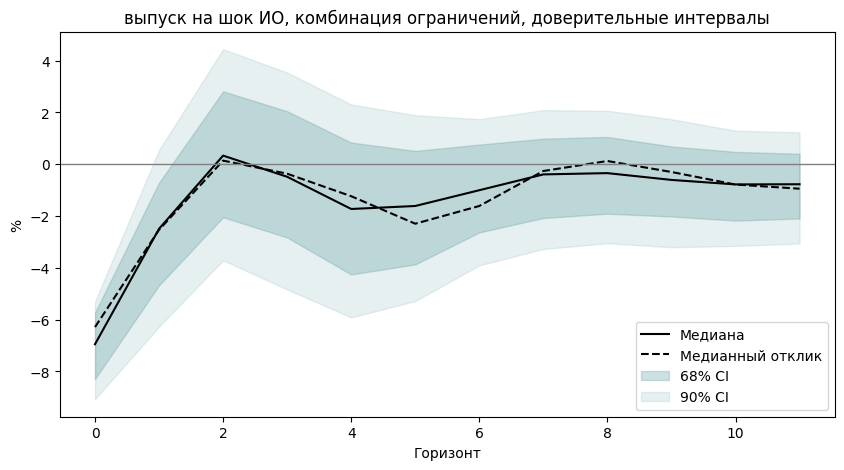

Вероятность, что суммарный отклик положительный 0.117, горизонт 12 мес.
Медианный суммарный отклик  -16.87519, горизонт 12 мес.
Верхние 95% суммарный отклик  17.55364, горизонт 12 мес.
Нижние 5% суммарный отклик  -54.78017, горизонт 12 мес.
[1, 2]


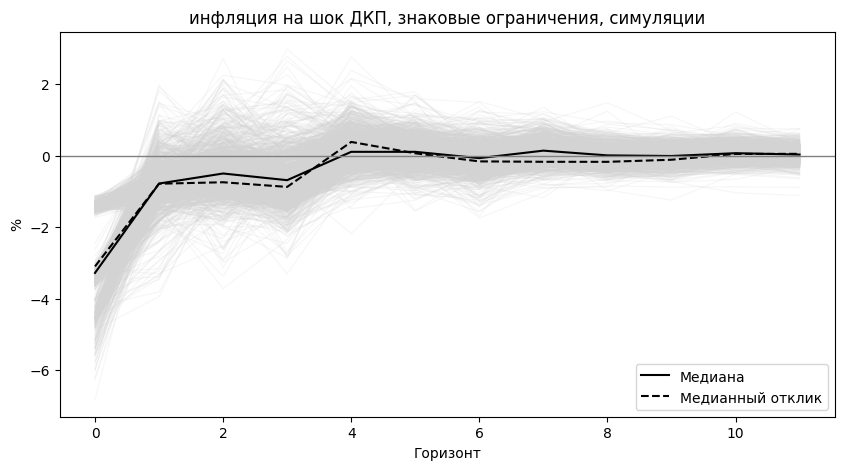

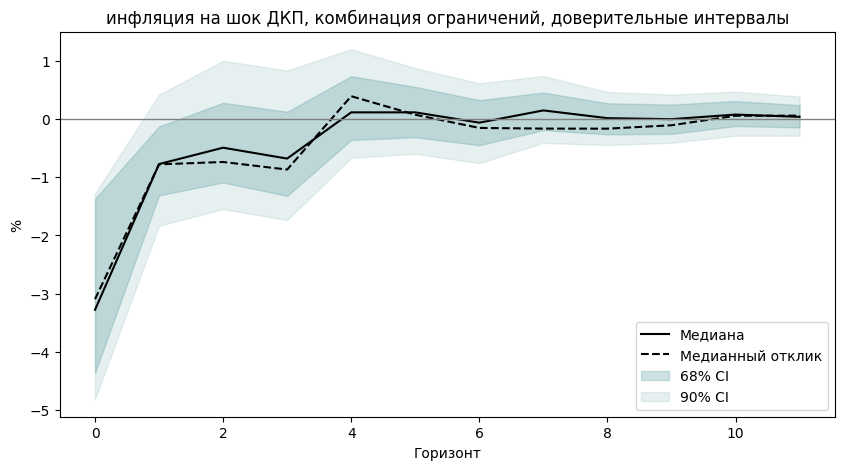

Вероятность, что суммарный отклик отрицательный 0.967, горизонт 12 мес.
Медианный суммарный отклик  -4.81065, горизонт 12 мес.
Верхние 95% суммарный отклик  6.10374, горизонт 12 мес.
Нижние 5% суммарный отклик  -13.8074, горизонт 12 мес.
[1, 3]


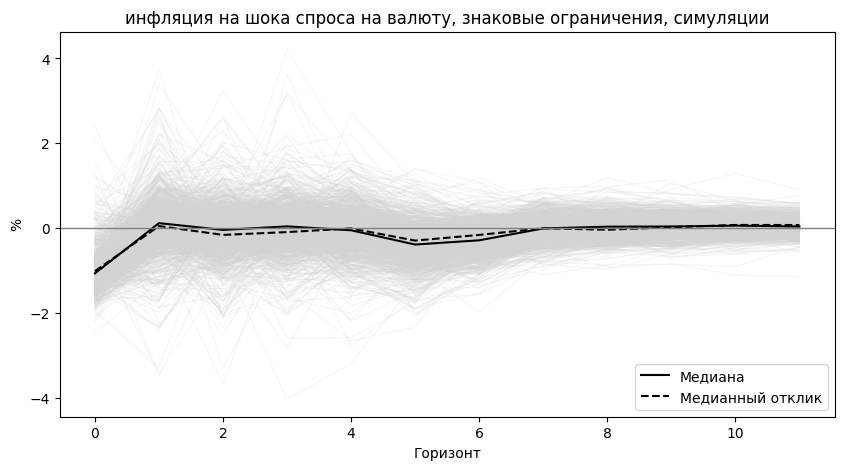

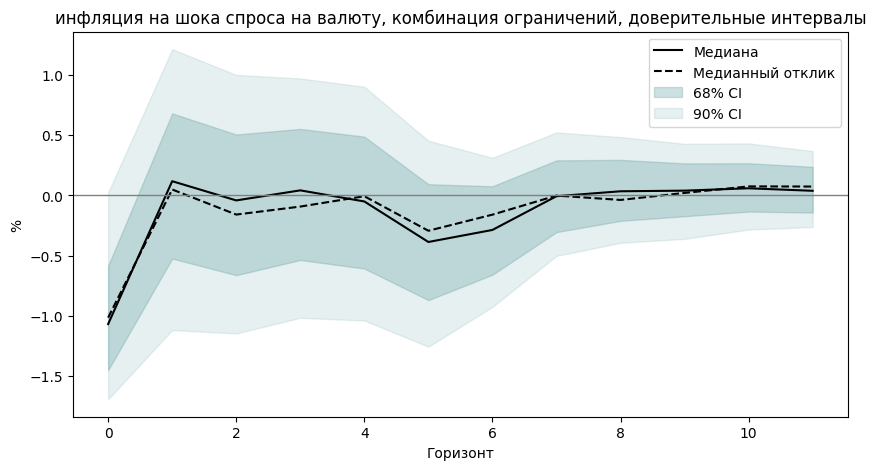

Вероятность, что суммарный отклик отрицательный 0.746, горизонт 12 мес.
Медианный суммарный отклик  -1.51677, горизонт 12 мес.
Верхние 95% суммарный отклик  7.09815, горизонт 12 мес.
Нижние 5% суммарный отклик  -9.99598, горизонт 12 мес.
[1, 4]


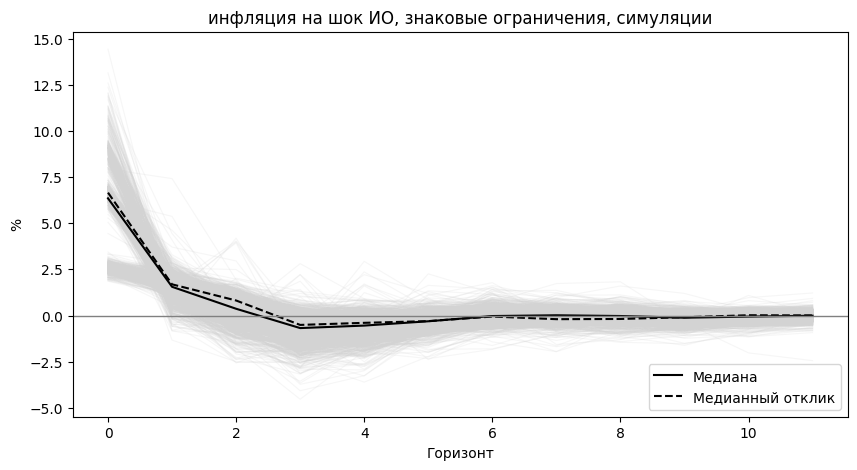

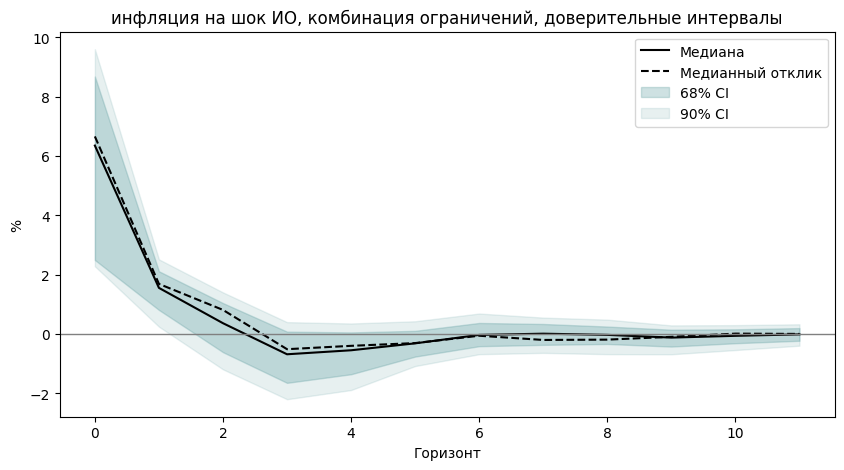

Вероятность, что суммарный отклик отрицательный 0.007, горизонт 12 мес.
Медианный суммарный отклик  6.50045, горизонт 12 мес.
Верхние 95% суммарный отклик  17.35997, горизонт 12 мес.
Нижние 5% суммарный отклик  -7.41611, горизонт 12 мес.
[2, 2]


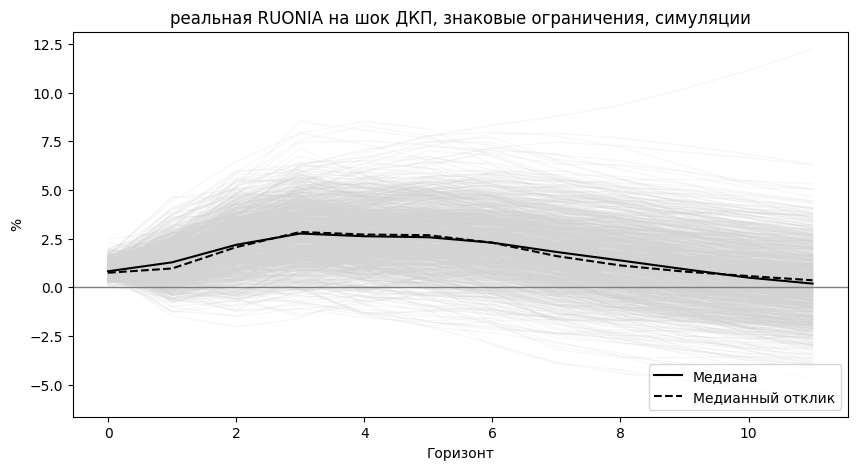

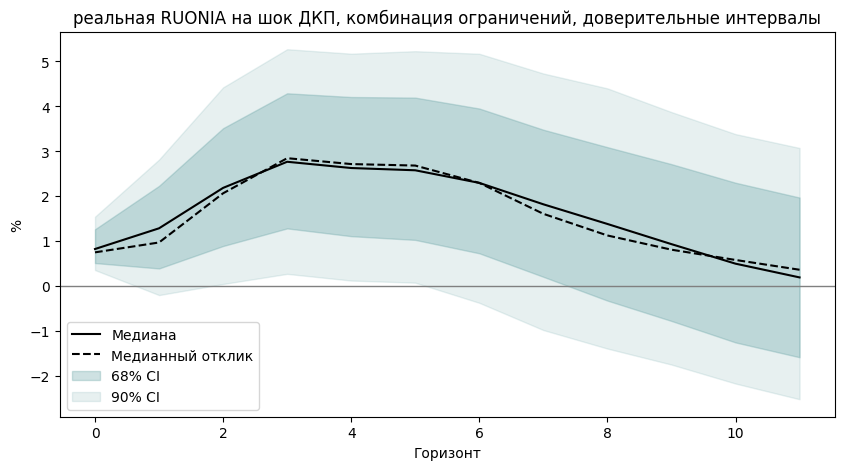

Вероятность, что суммарный отклик положительный 0.922, горизонт 12 мес.
Медианный суммарный отклик  19.37533, горизонт 12 мес.
Верхние 95% суммарный отклик  49.03975, горизонт 12 мес.
Нижние 5% суммарный отклик  -8.49305, горизонт 12 мес.
[2, 3]


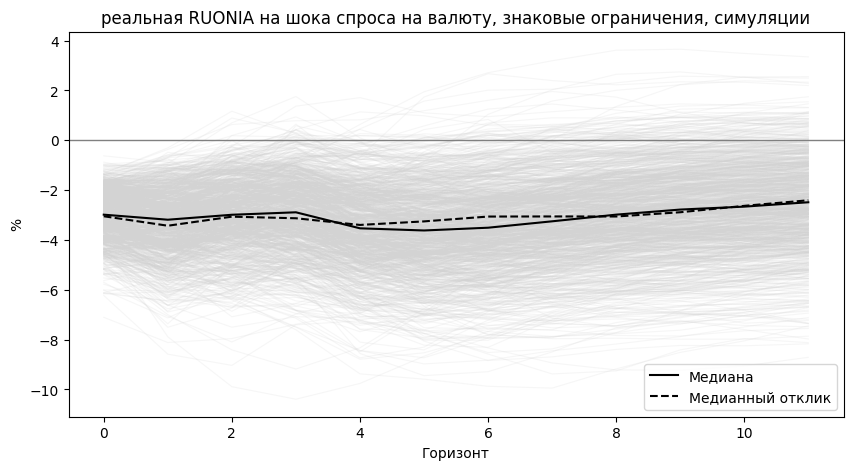

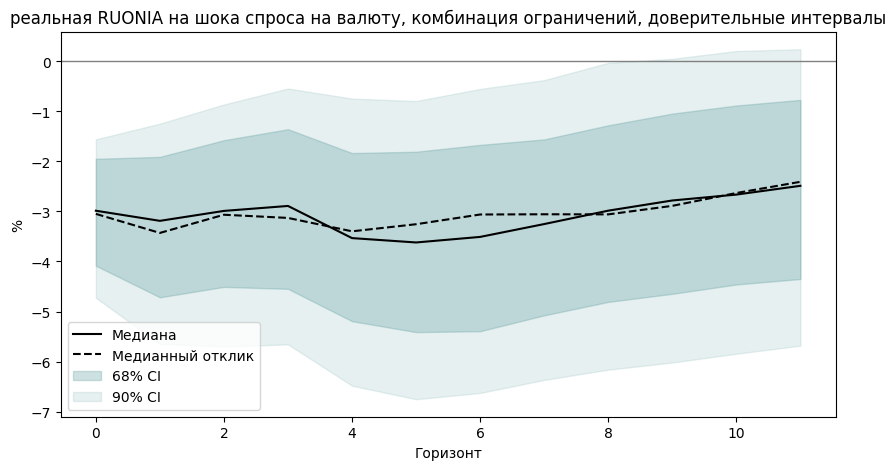

Вероятность, что суммарный отклик положительный 0.005, горизонт 12 мес.
Медианный суммарный отклик  -36.88323, горизонт 12 мес.
Верхние 95% суммарный отклик  -6.20165, горизонт 12 мес.
Нижние 5% суммарный отклик  -71.67513, горизонт 12 мес.
[2, 4]


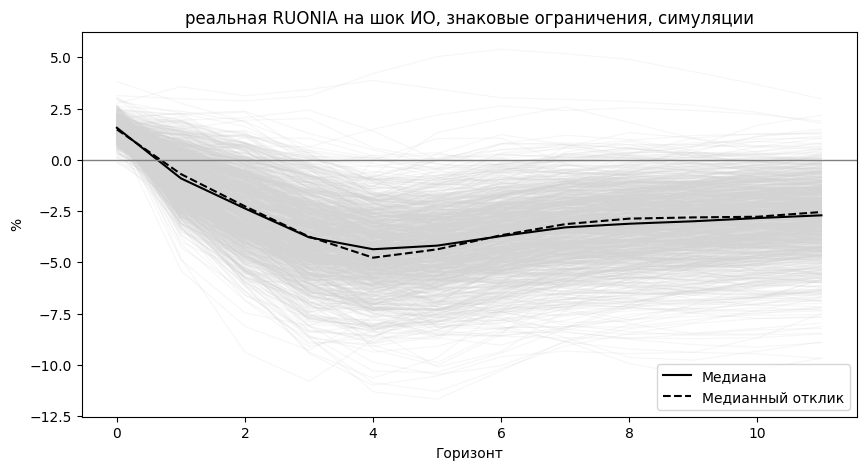

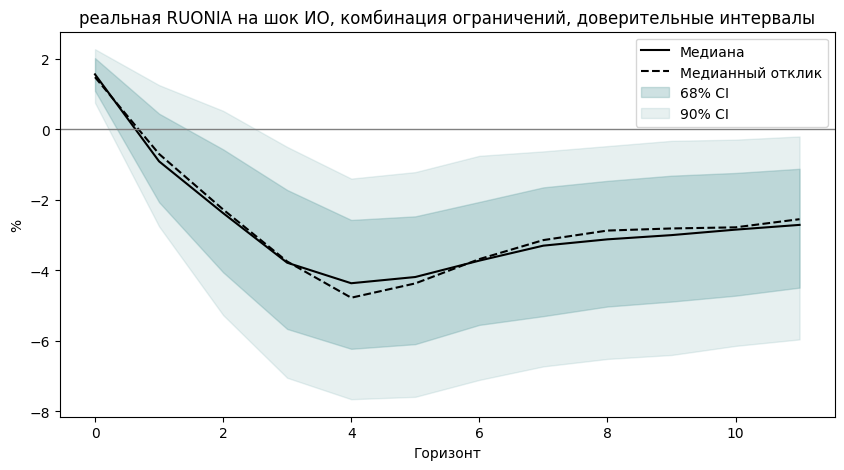

Вероятность, что суммарный отклик положительный 0.013, горизонт 12 мес.
Медианный суммарный отклик  -32.74808, горизонт 12 мес.
Верхние 95% суммарный отклик  -1.71399, горизонт 12 мес.
Нижние 5% суммарный отклик  -68.39796, горизонт 12 мес.
[3, 2]


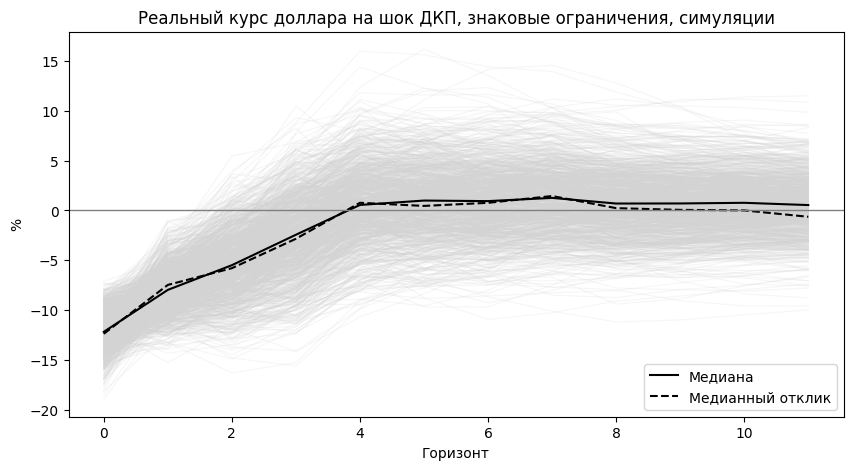

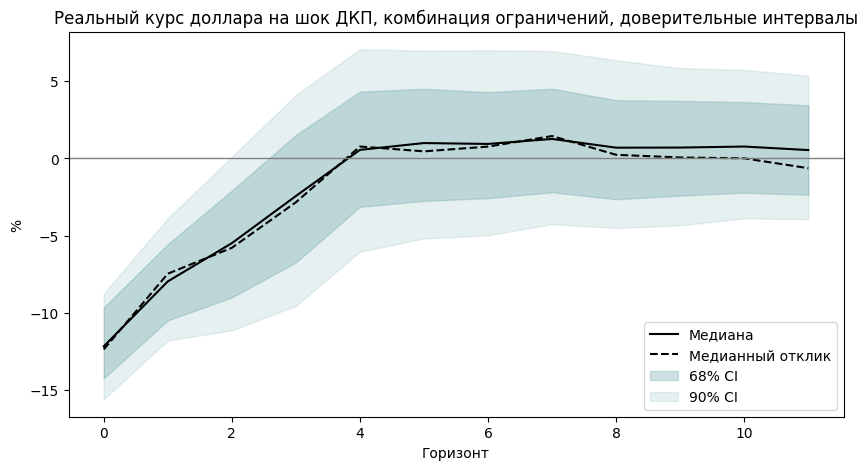

Вероятность, что суммарный отклик положительный 0.202, горизонт 12 мес.
Медианный суммарный отклик  -21.68257, горизонт 12 мес.
Верхние 95% суммарный отклик  42.81708, горизонт 12 мес.
Нижние 5% суммарный отклик  -85.25687, горизонт 12 мес.
[3, 3]


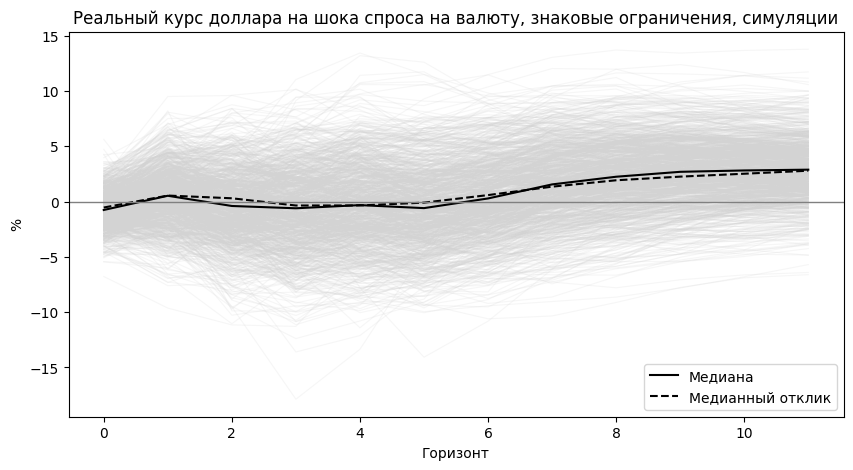

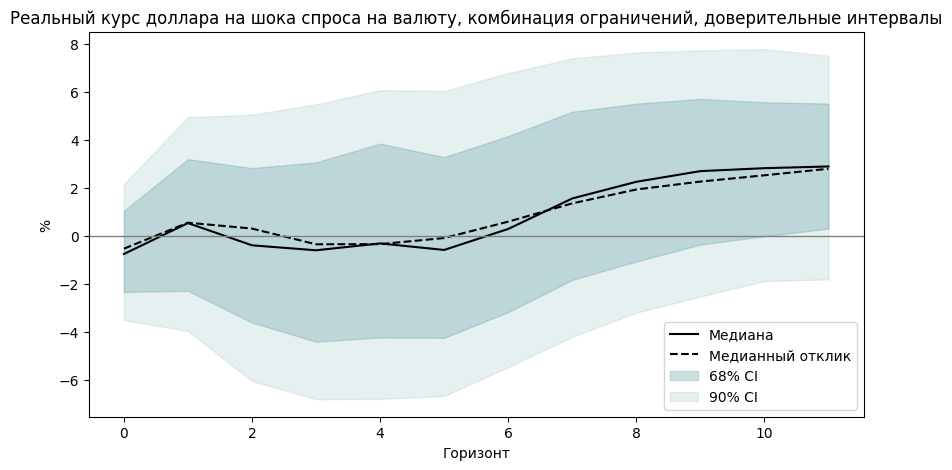

Вероятность, что суммарный отклик положительный 0.636, горизонт 12 мес.
Медианный суммарный отклик  10.3065, горизонт 12 мес.
Верхние 95% суммарный отклик  74.46123, горизонт 12 мес.
Нижние 5% суммарный отклик  -52.94553, горизонт 12 мес.
[3, 4]


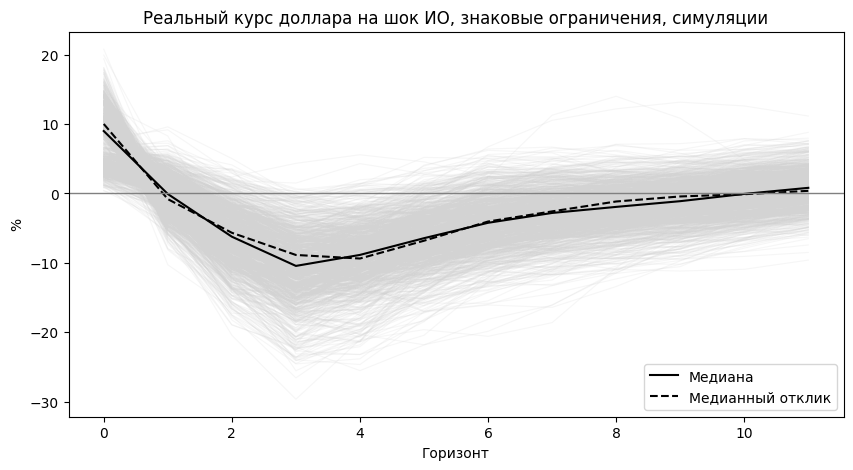

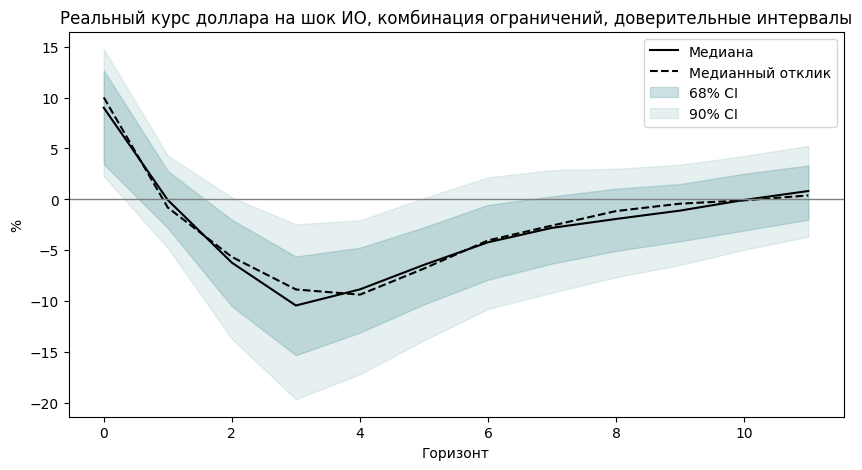

Вероятность, что суммарный отклик положительный 0.093, горизонт 12 мес.
Медианный суммарный отклик  -32.38695, горизонт 12 мес.
Верхние 95% суммарный отклик  35.70307, горизонт 12 мес.
Нижние 5% суммарный отклик  -109.66817, горизонт 12 мес.
[4, 2]


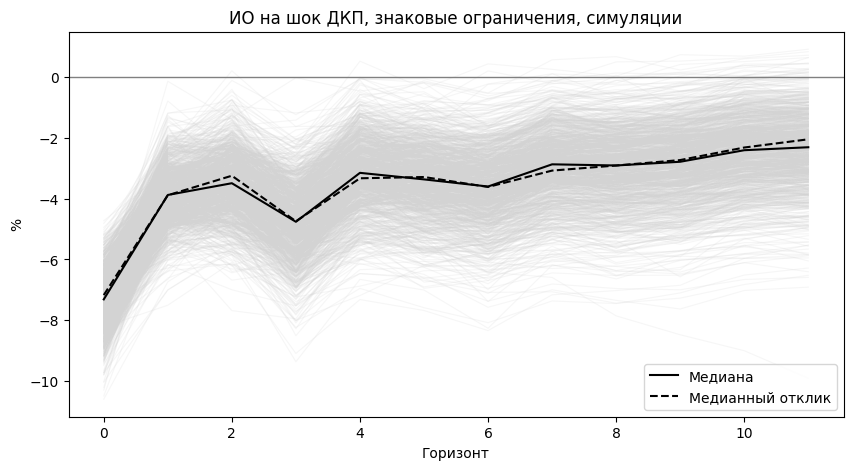

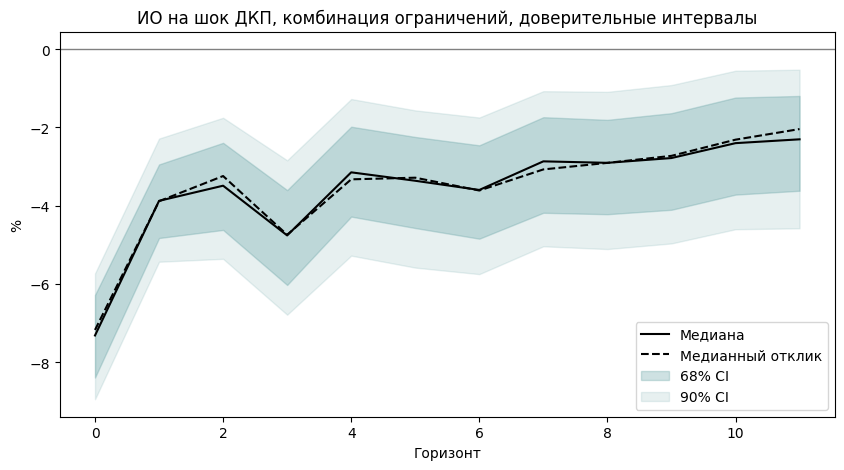

Вероятность, что суммарный отклик положительный 0.0, горизонт 12 мес.
Медианный суммарный отклик  -42.78859, горизонт 12 мес.
Верхние 95% суммарный отклик  -21.33229, горизонт 12 мес.
Нижние 5% суммарный отклик  -67.39723, горизонт 12 мес.
[4, 3]


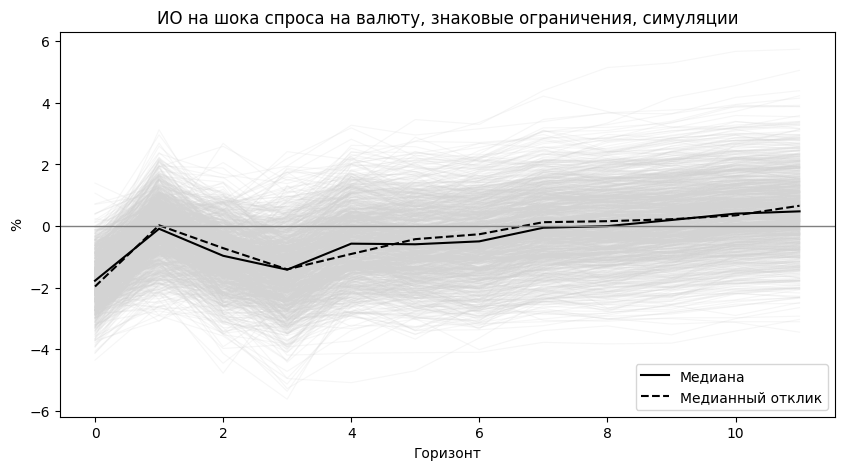

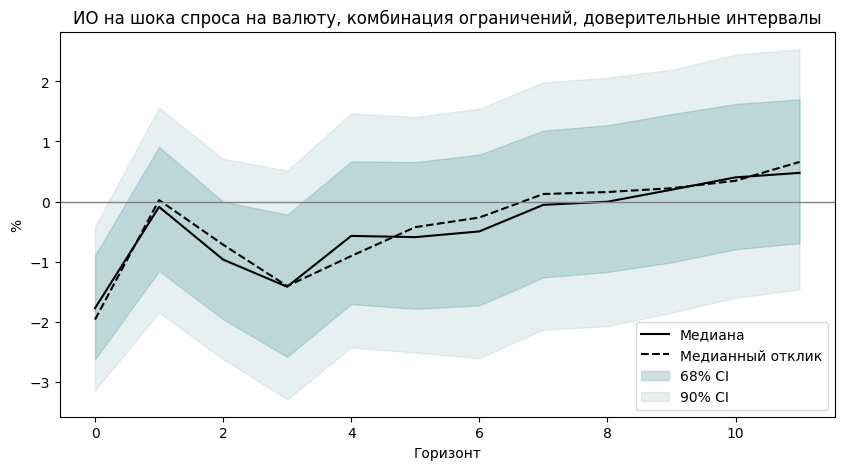

Вероятность, что суммарный отклик положительный 0.349, горизонт 12 мес.
Медианный суммарный отклик  -4.89074, горизонт 12 мес.
Верхние 95% суммарный отклик  17.98443, горизонт 12 мес.
Нижние 5% суммарный отклик  -27.54919, горизонт 12 мес.
[4, 4]


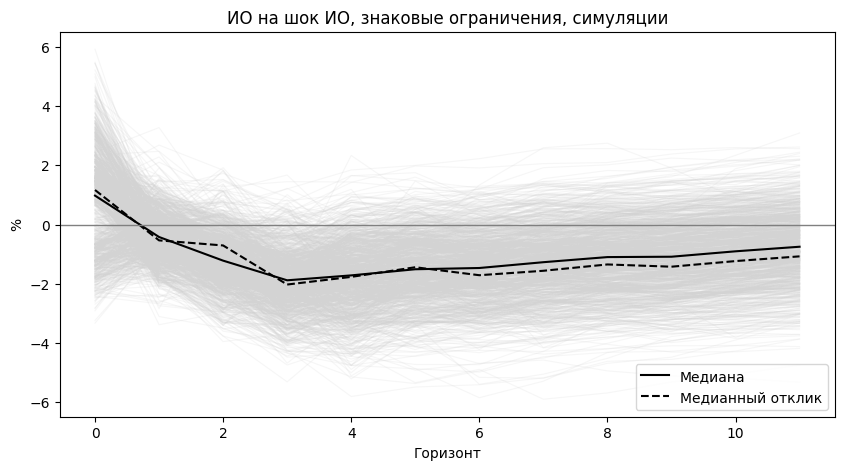

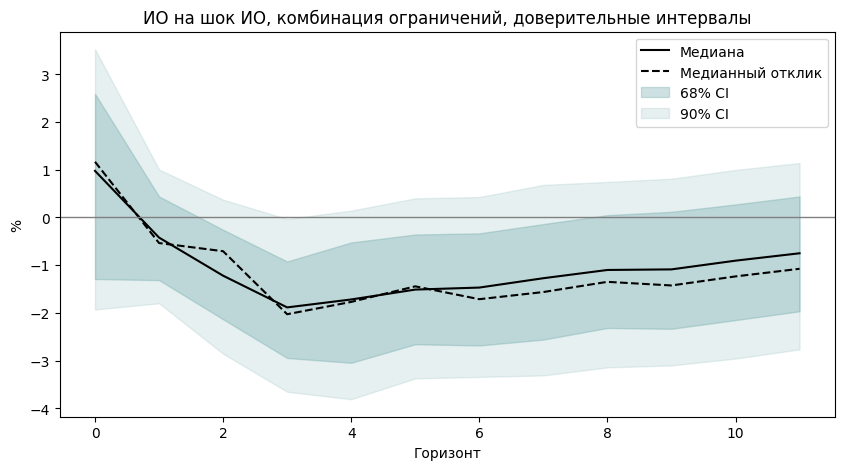

Вероятность, что суммарный отклик положительный 0.117, горизонт 12 мес.
Медианный суммарный отклик  -12.37564, горизонт 12 мес.
Верхние 95% суммарный отклик  10.21343, горизонт 12 мес.
Нижние 5% суммарный отклик  -36.04599, горизонт 12 мес.


In [11]:


for i, j in [(i, j) for i in range(K_endo) for j in range(2, K_endo)]:
    irf = IRF_ortho[0]
    response = [i, j]
    print(response)
    virf = irf[:, response[0], response[1]]
    
    for irf in IRF_ortho[1:]:
        virf = np.vstack([virf, irf[:, response[0], response[1]]])
    median_index = pd.DataFrame((virf - np.median(virf, axis = 0))**2).sum(1).sort_values().index[0]
    import matplotlib.pyplot as plt

    # Имитация матрицы: 10000 симуляций × 20 шагов
    np.random.seed(0)
    responses = virf
    rescale = False
    if rescale:
        depend = data.iloc[response[0]].std()
        shock = data.iloc[response[1]].std()
        virf *= shock/depend
    # Квантили
    if j == 2:
        sign = 1
    else:
        sign = 1
    median = sign*np.percentile(responses, 50, axis=0)
    lower68 = sign*np.percentile(responses, 16, axis=0)
    upper68 = sign*np.percentile(responses, 84, axis=0)
    lower90 = sign*np.percentile(responses, 5, axis=0)
    upper90 = sign*np.percentile(responses, 95, axis=0)
    med_res = sign*virf[median_index, :]
    median_s = median.sum()
    upper90_s = upper90.sum()
    # Горизонты
    x_axis = np.arange(horizon)
    plt.figure(figsize=(10,5))
    plt.plot(x_axis, virf.T, color="lightgray", alpha=0.2, linewidth=0.8, label="_nolabel_")
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend(loc = 'lower right')
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, знаковые ограничения, симуляции")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.fill_between(x_axis, lower68, upper68, color='cadetblue', alpha=0.3, label='68% CI')
    plt.fill_between(x_axis, lower90, upper90, color='cadetblue', alpha=0.15, label='90% CI')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend()
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, комбинация ограничений, доверительные интервалы")
    plt.show()
    print(f"Вероятность, что суммарный отклик {'отрицательный' if i == 1 else 'положительный'} {((virf.sum(axis = 1) < 0).sum()/required)\
                                                                         .item() if i == 1 else ((virf.sum(axis = 1) > 0).sum()/required).item()}, горизонт {horizon} мес.")
    print(f"Медианный суммарный отклик  {np.round(np.median(virf, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Верхние 95% суммарный отклик  {np.round(np.quantile(virf, 0.95, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Нижние 5% суммарный отклик  {np.round(np.quantile(virf, 0.05, axis = 0).sum(), 5)}, горизонт {horizon} мес.")

In [12]:
import matplotlib.pyplot as plt

def plot_hd_bars_signed(df_hd, variable_name="y", shocks_labels=None, cumm = True):
    shocks_labels = shocks_labels or df_hd.columns
    x = np.arange(len(df_hd))

    plt.figure(figsize=(10, 6))

    # Основания для положительных и отрицательных значений
    bottom_pos = np.zeros(len(df_hd))
    bottom_neg = np.zeros(len(df_hd))

    # Используем палитру заранее, чтобы цвета не повторялись
    list_of_colors = ['goldenrod', 'firebrick', 'yellowgreen', 'cadetblue', 'hotpink']
    colors = list_of_colors[:len(shocks_labels)]

    for i, shock in enumerate(shocks_labels):
        values = df_hd[shock].values
        pos = np.where(values > 0, values, 0)
        neg = np.where(values < 0, values, 0)

        color = colors[i]

        # Рисуем обе части одним цветом
        plt.bar(x, pos, bottom=bottom_pos, color=color, alpha=0.8)
        plt.bar(x, neg, bottom=bottom_neg, color=color, alpha=0.8, label=shock)

        # Обновляем основания
        bottom_pos += pos
        bottom_neg += neg

    plt.xticks(
        ticks=x[::max(1, len(x)//10)],
        labels=[str(d)[:10] for d in df_hd.index[::max(1, len(x)//10)]],
        rotation=45,
        ha="right"
    )

    plt.axhline(0, color="black", linewidth=0.8)
    plt.title(f"{'Накопленная историческая декомпозиция' if cumm else 'Историческая декомпозиция'}: {variable_name}")
    plt.legend(loc="upper left", fontsize=9)
    plt.xlabel("Время")
    plt.ylabel("Вклад шоков")
    plt.tight_layout()
    plt.show()

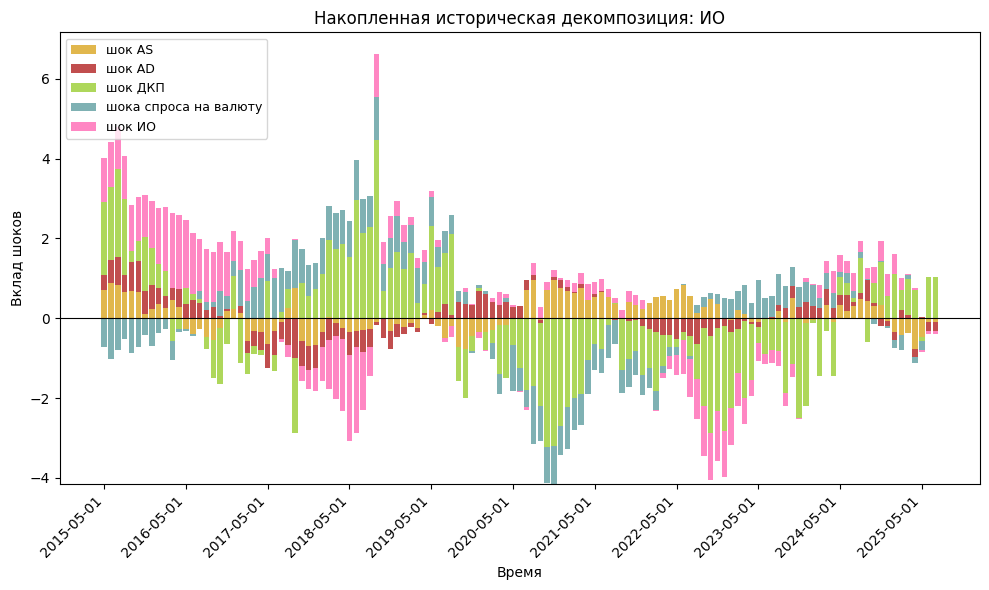

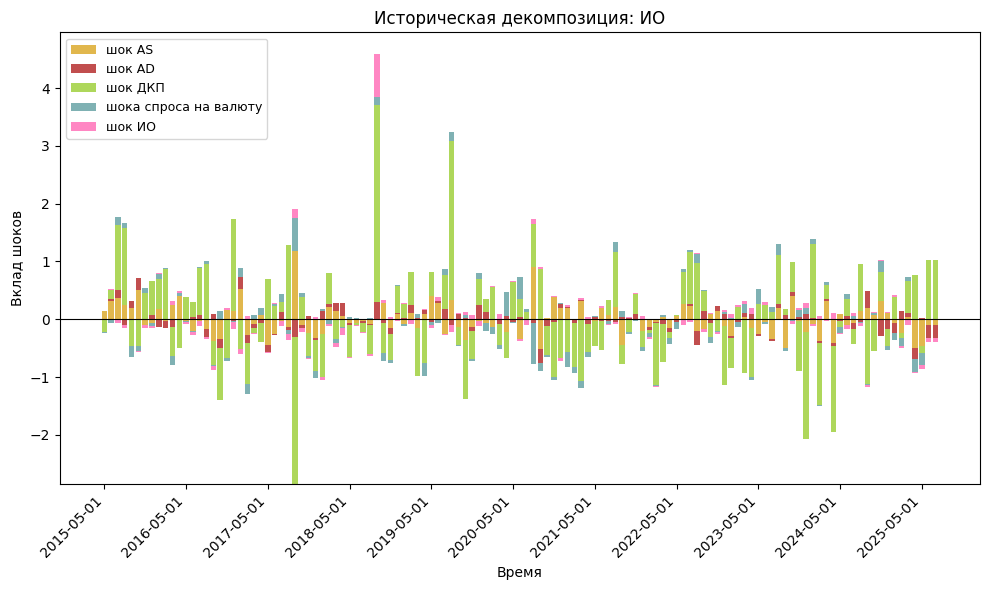

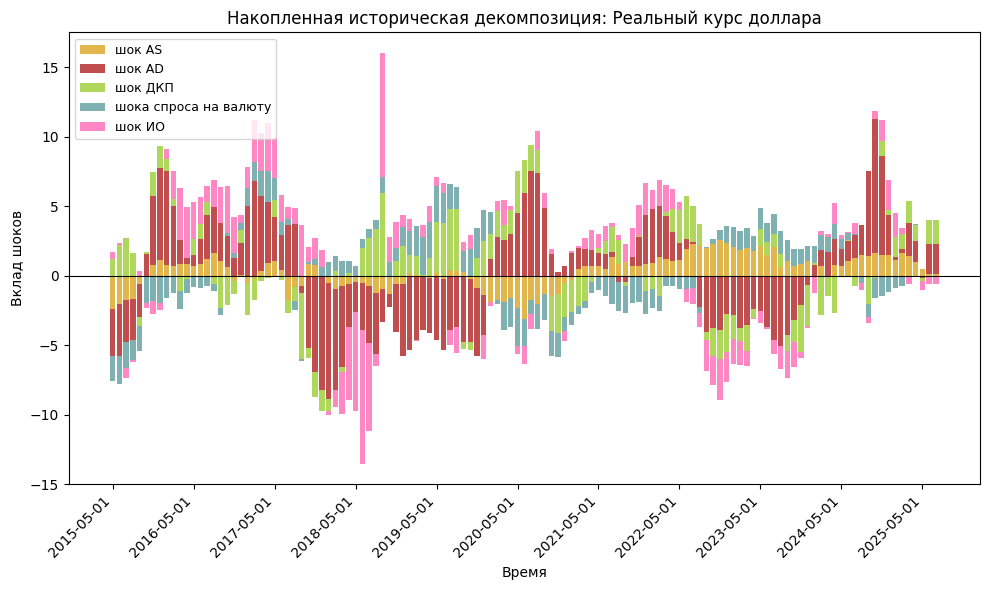

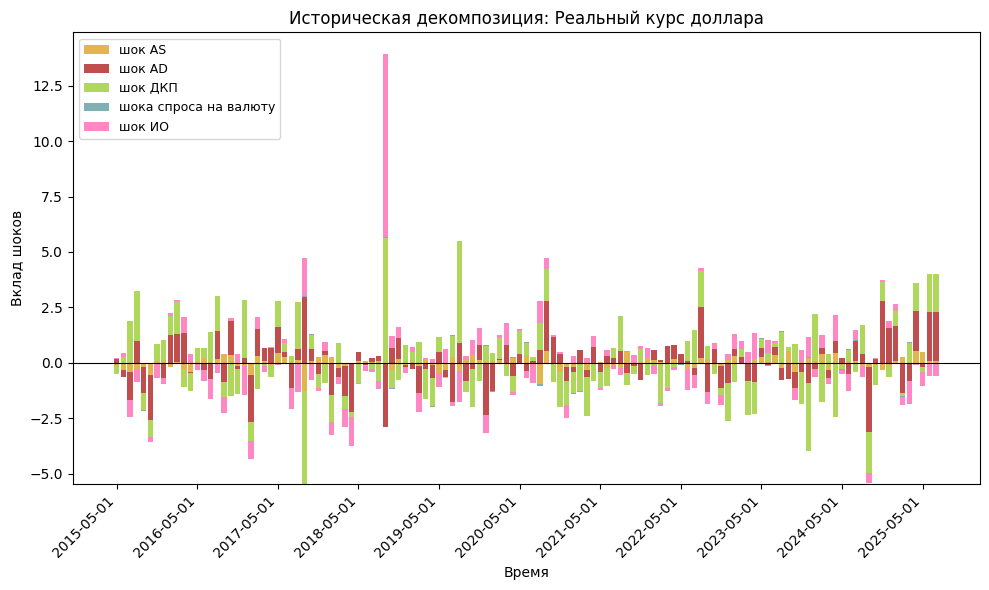

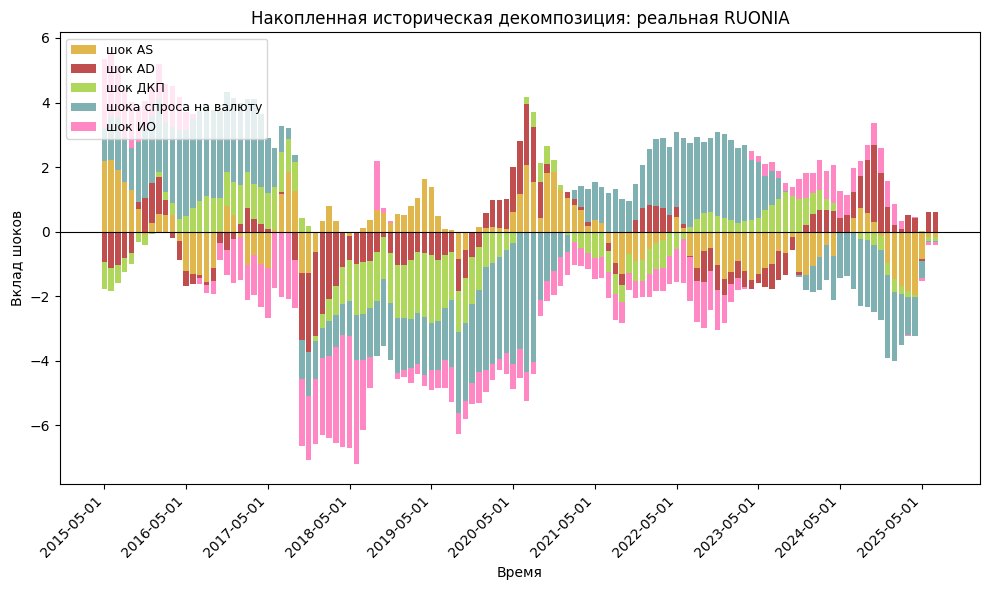

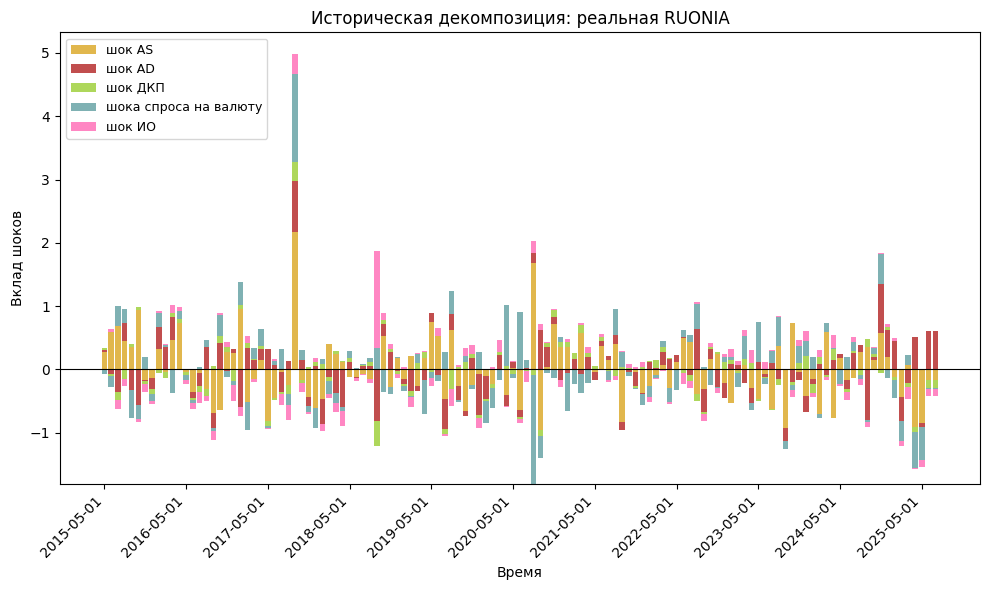

In [13]:
B0 = np.linalg.inv(P @ Q)
U = B0 @ E
U = np.flip(U, axis = 1)
irf = irf_companion(B_hat_endo[:, 1:], P@ Q, U.shape[1])
hd = [irf[0]*U[:, 0]]
chd = [irf[0]*U[:, 0]]
for t in range(U.shape[1]):
    contrib_t = irf[0]*U[:, t]
    
    hd.append(contrib_t)

    contrib_c = irf[0]*U[:, t]
    for h in range(1, t):  
        contrib_c += irf[h]*U[:, t-h] #Этот цикл отвечает за накопленные отклики
    chd.append(contrib_c)

    del contrib_t, contrib_c

variable_of_interest = 4 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(np.flip(y_hd, axis = 0), columns = [i for i in u_dict.values()], 
                    index = data.columns[:y_hd.shape[0]].to_list()[::-1]) #вот не накопленные отклики
y_chd = pd.DataFrame(np.flip(y_chd, axis = 0), columns = [i for i in u_dict.values()], 
                    index = data.columns[:y_chd.shape[0]].to_list()[::-1]) #вот накопленные отклики
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)

variable_of_interest = 3 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(np.flip(y_hd, axis = 0), columns = [i for i in u_dict.values()], 
                    index = data.columns[:y_hd.shape[0]].to_list()[::-1]) #вот не накопленные отклики
y_chd = pd.DataFrame(np.flip(y_chd, axis = 0), columns = [i for i in u_dict.values()], 
                    index = data.columns[:y_chd.shape[0]].to_list()[::-1]) #вот накопленные отклики
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)

variable_of_interest = 2 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(np.flip(y_hd, axis = 0), columns = [i for i in u_dict.values()], 
                    index = data.columns[:y_hd.shape[0]].to_list()[::-1]) #вот не накопленные отклики
y_chd = pd.DataFrame(np.flip(y_chd, axis = 0), columns = [i for i in u_dict.values()], 
                    index = data.columns[:y_chd.shape[0]].to_list()[::-1]) #вот накопленные отклики
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)